# JP Morgan Quantiative Analyst Code

In [52]:
#firt import related libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
df = pd.read_csv("Nat_Gas.csv",
                parse_dates=["Dates"],
                index_col=0)

In [54]:
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


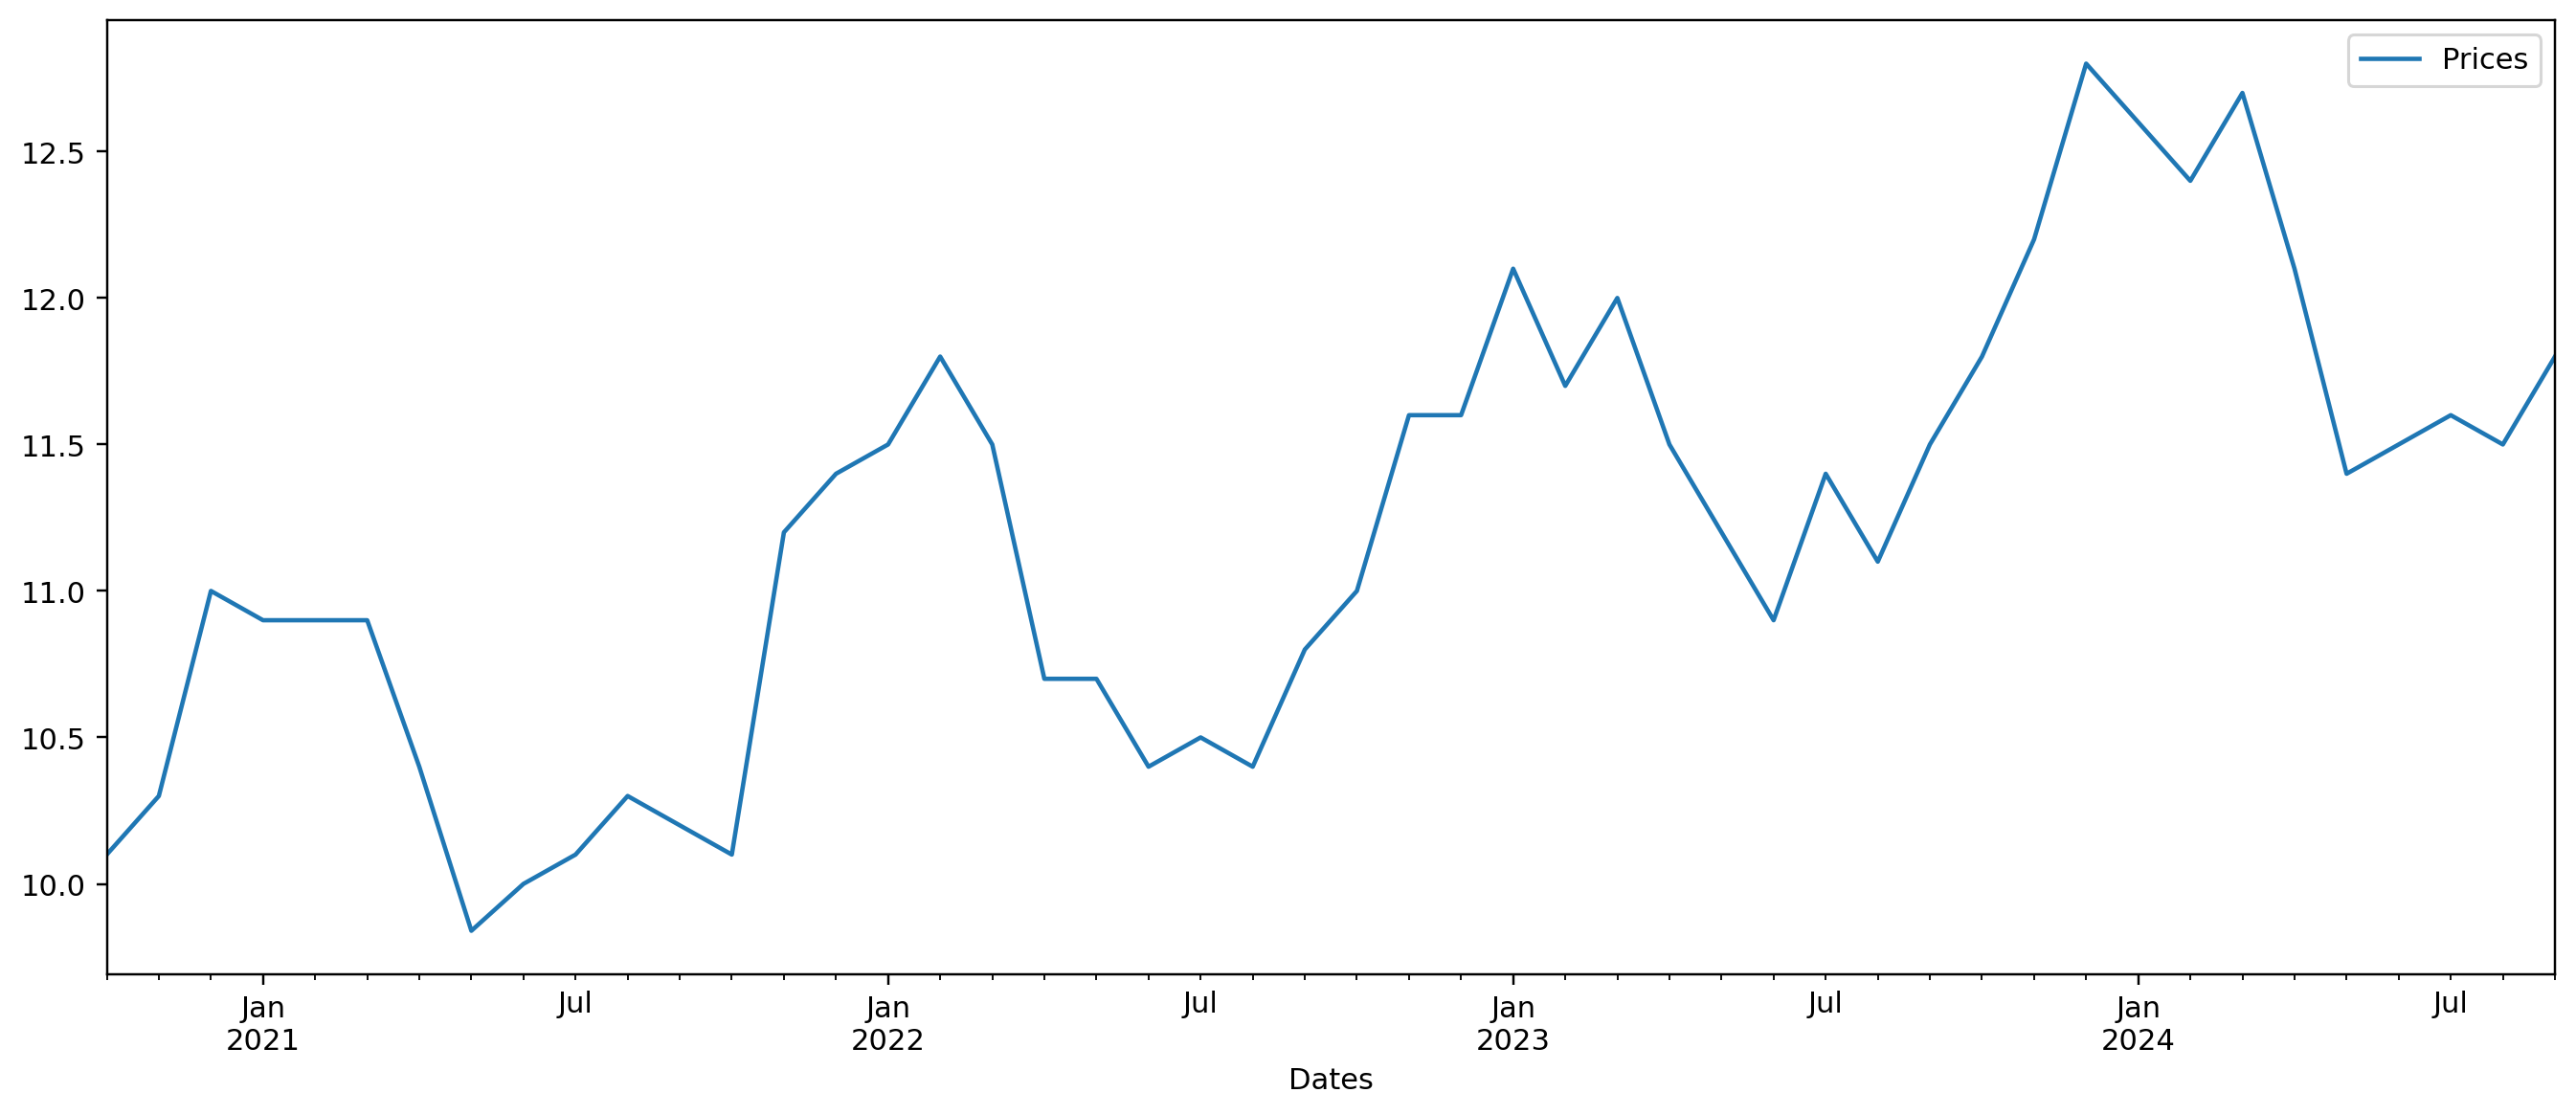

In [55]:
df.plot(kind = "line",figsize = (15,6))
plt.show() 


## Detecting Trends

I can see the prices increases over years but the problem is the increase is not balanced. There is so many ups and downs, so this data is probably *not stationary*. And also I see that the data follows an **upwarding trend**. So I will try to understand if the trend is **cylical** or its **seasonal**.

To detect trends I will use Hodrick-Prescott Filter.

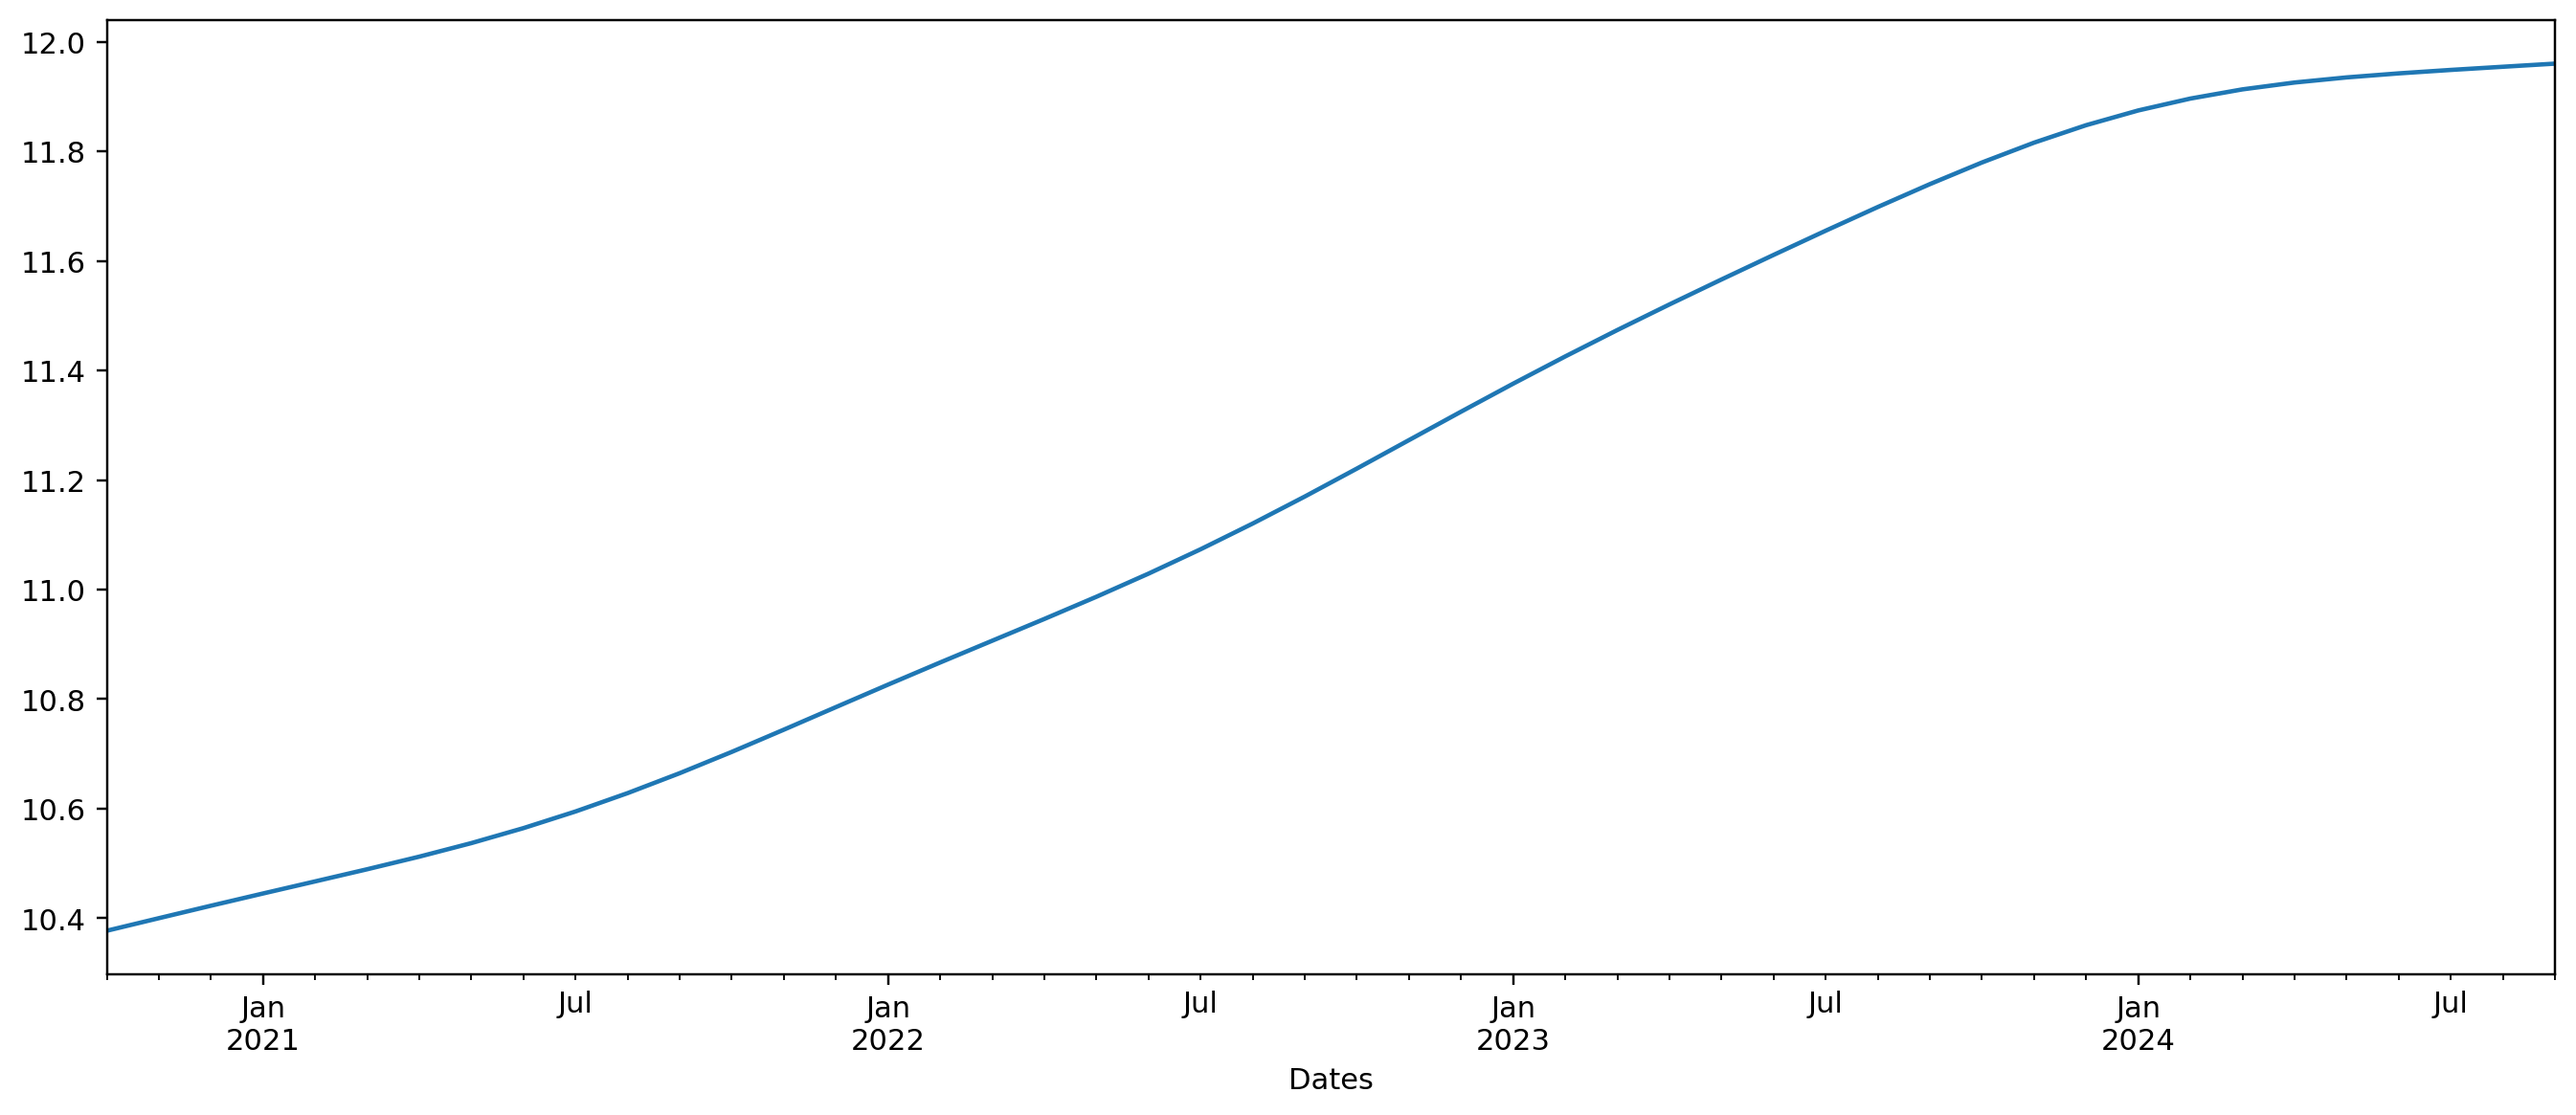

In [56]:
from statsmodels.tsa.filters.hp_filter import hpfilter

price_cycle, price_trend = hpfilter(df["Prices"],lamb=1600)

price_trend.plot(figsize = (15,6)).autoscale(axis = "x",tight = True)

## Removing Trends

Here in the graph I see that there is a upwarding trend over time. I need to remove this trend or it menations a change in the mean. But I want the mean to be stable always to understand time series and to predict it with models like AR, MA, ARIMA, SARIMA etc..

To detrending a time series I can use 3 options:

* Pandas Differencing

* SciPy signal

* HP Filter

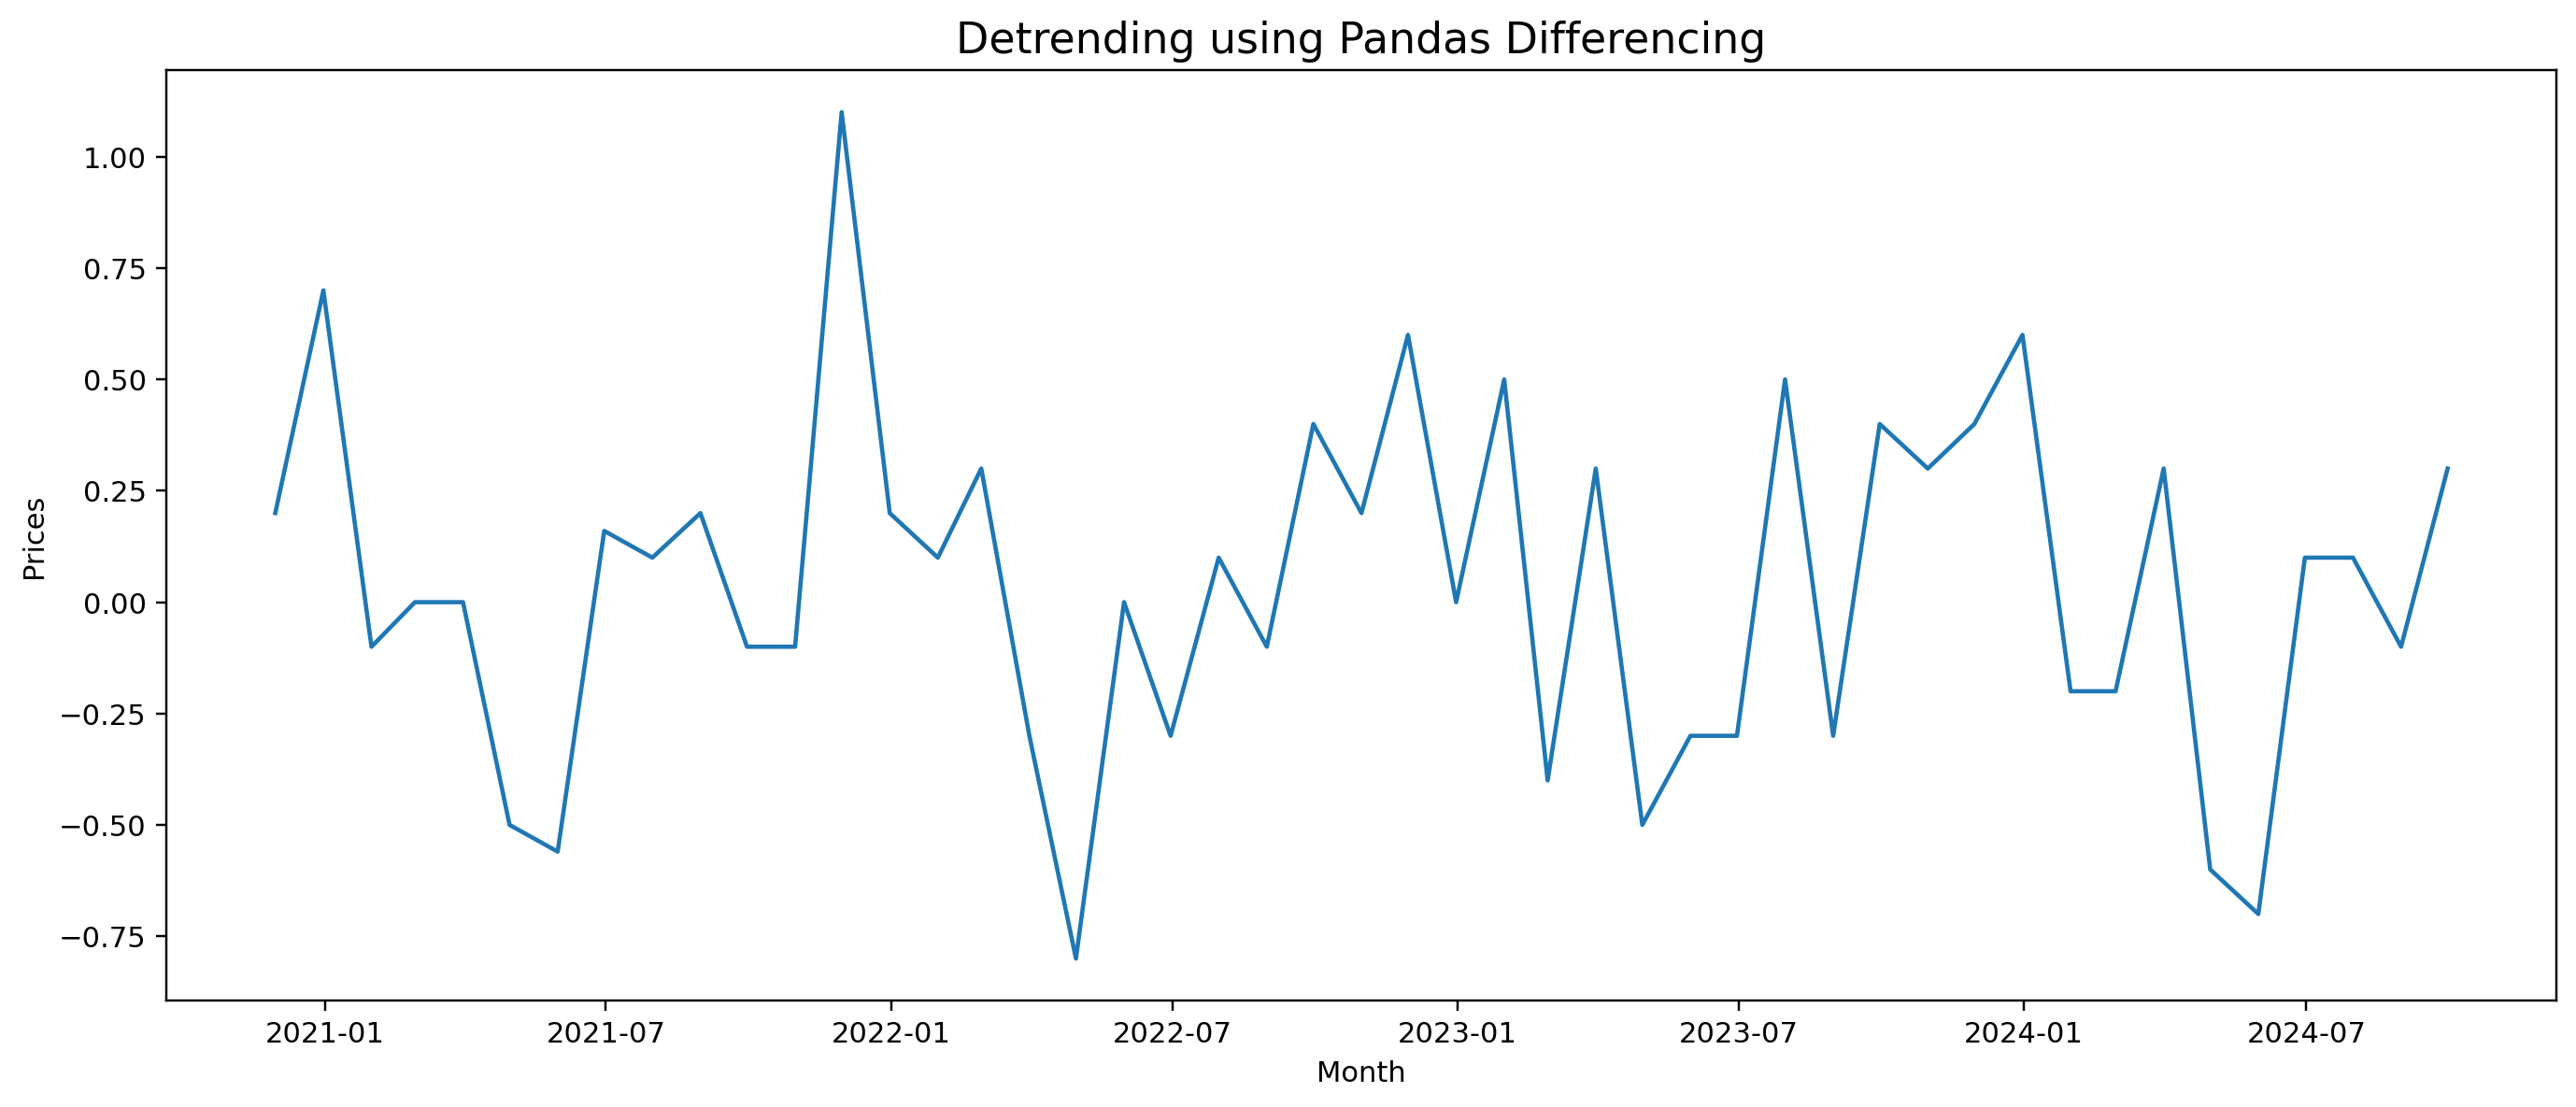

In [57]:
#using pandas
import warnings
warnings.filterwarnings("ignore")

diff = df.Prices.diff() #differentiating

plt.figure(figsize=(15,6))
plt.plot(diff) #plotting the differentiated series
plt.title("Detrending using Pandas Differencing", fontsize = 15)
plt.xlabel("Month")
plt.ylabel("Prices")
plt.show()

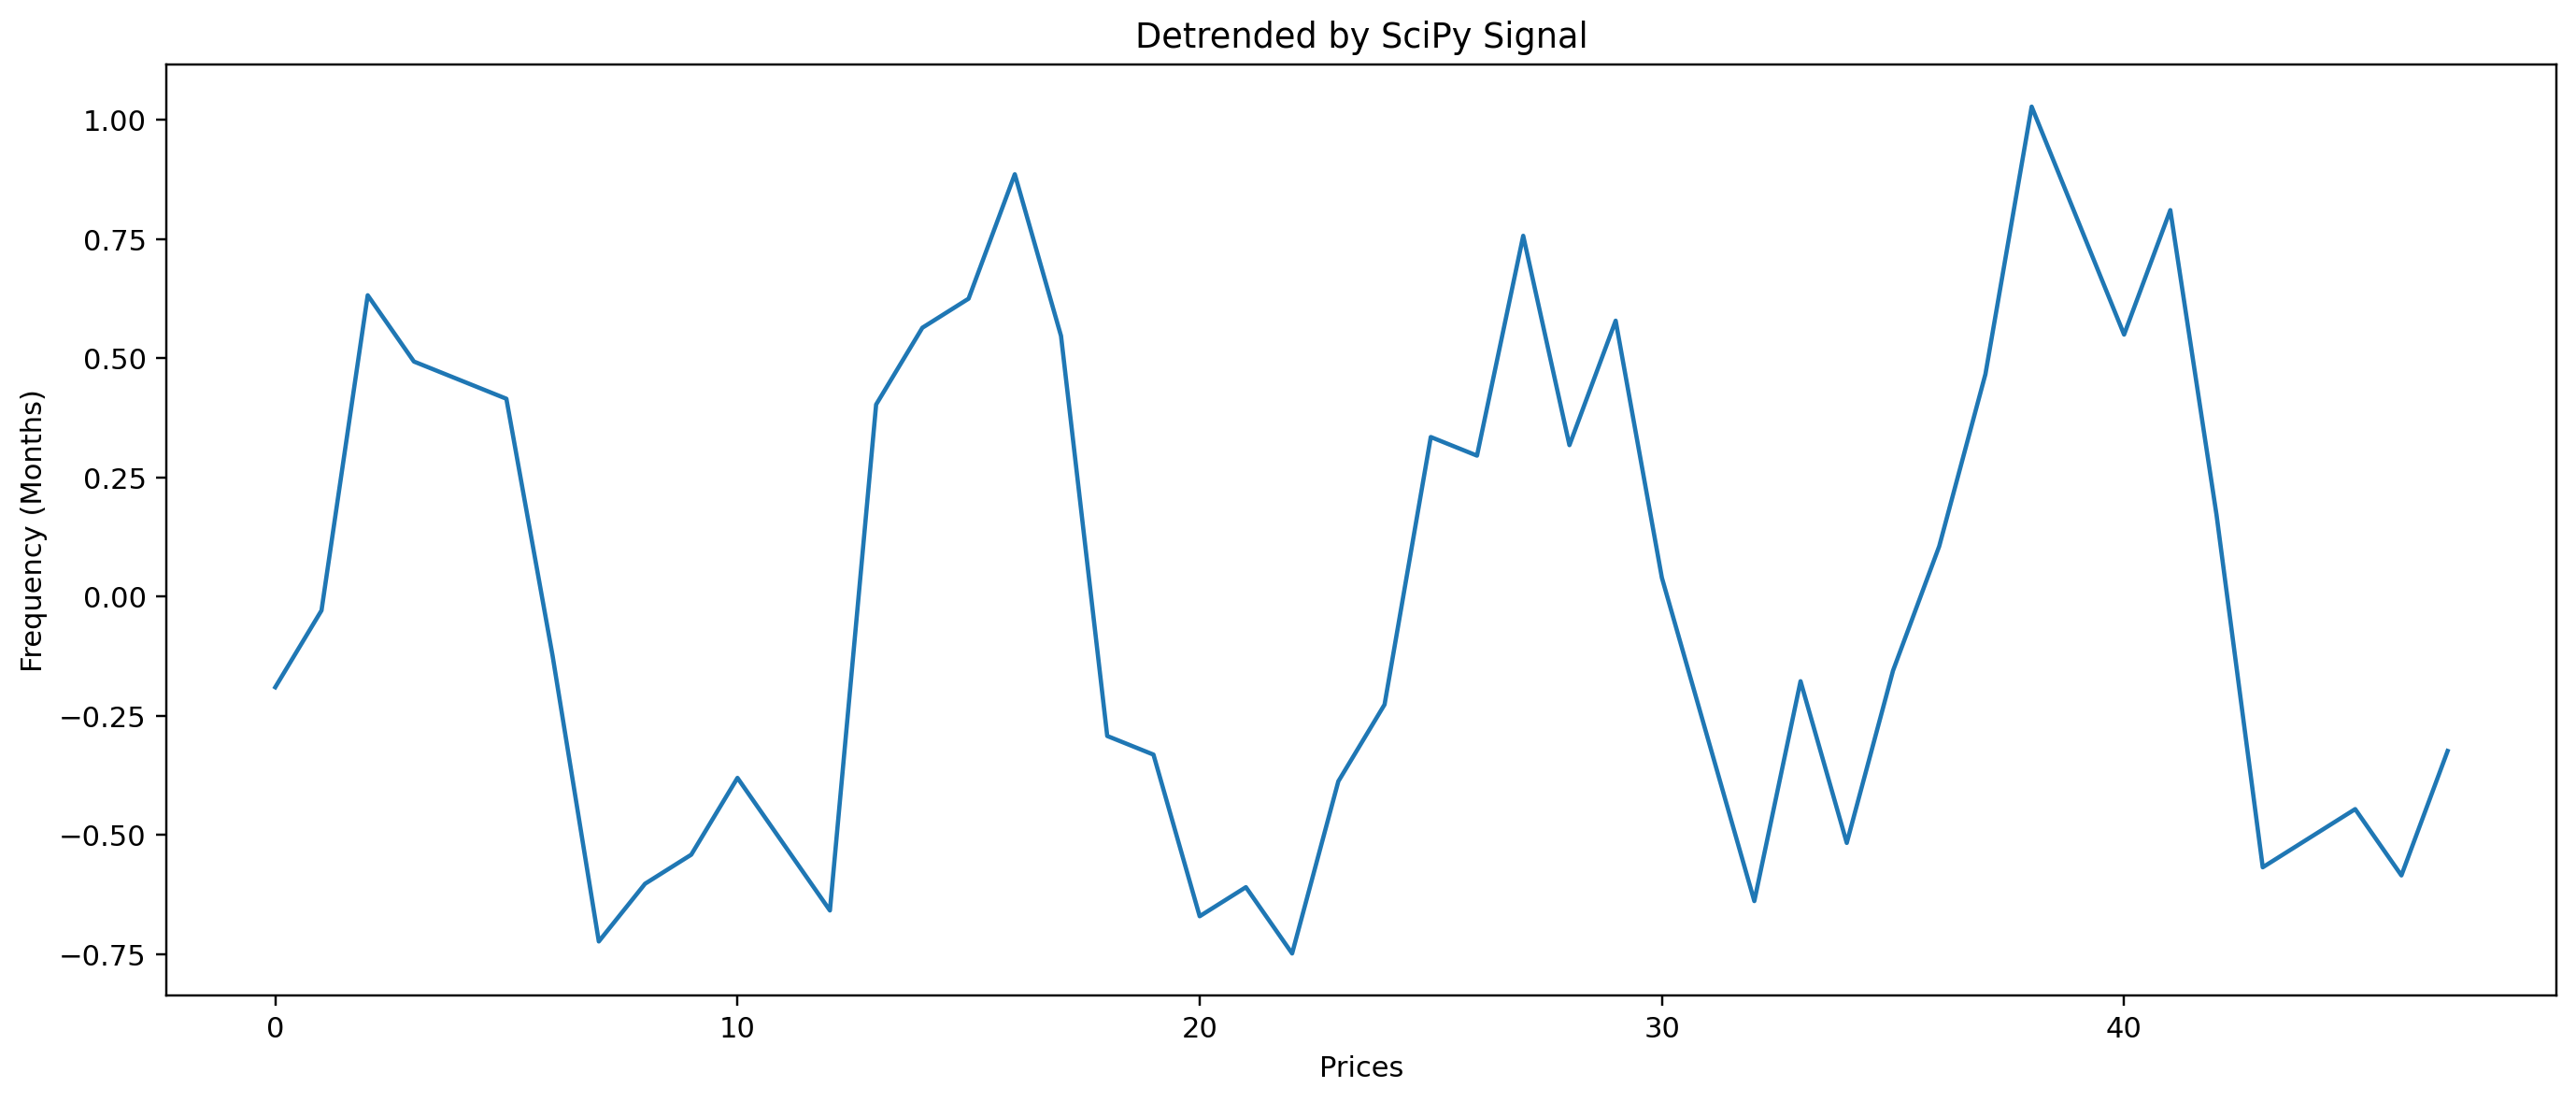

In [58]:
from scipy import signal
warnings.filterwarnings("ignore")

detrended_sp = signal.detrend(df.Prices.values)

plt.figure(figsize=(15,6))
plt.plot(detrended_sp)
plt.xlabel("Prices")
plt.ylabel("Frequency (Months)")
plt.title("Detrended by SciPy Signal")
plt.show()

# What is the difference between pandas .diff() and SciPy signal.detrend()?

There are some core differences:

* First of all the difference is about the calculation methods. pandas uses the yt and yt-1, it calculates the changes between lags. While SciPy substracts a fitted regression model and uses least square regression.

* Second is about trend: with pandas we remove linear or multiple trends while with Scipy we remove only linear trends.

* Third is the output mean. Pandas can not guarantee us to have a zero mean. Instead of zero mean we would have the average of changes in the y as mean. On the otherhand, in SciPy, because the method of its calculation is regression we would have a 0 mean.

* Forth is the model type; pandas is used for difference stationary series, like random walk. However, SciPy is used for trend stationary series, like deterministic trend.

* And the last one is the lenght. With pandas we have a series that 1 element shorter and in SciPy the lenght is the same.

If I use ARIMA, then ist better to use pandas but if i will use machine learning SciPy is better.

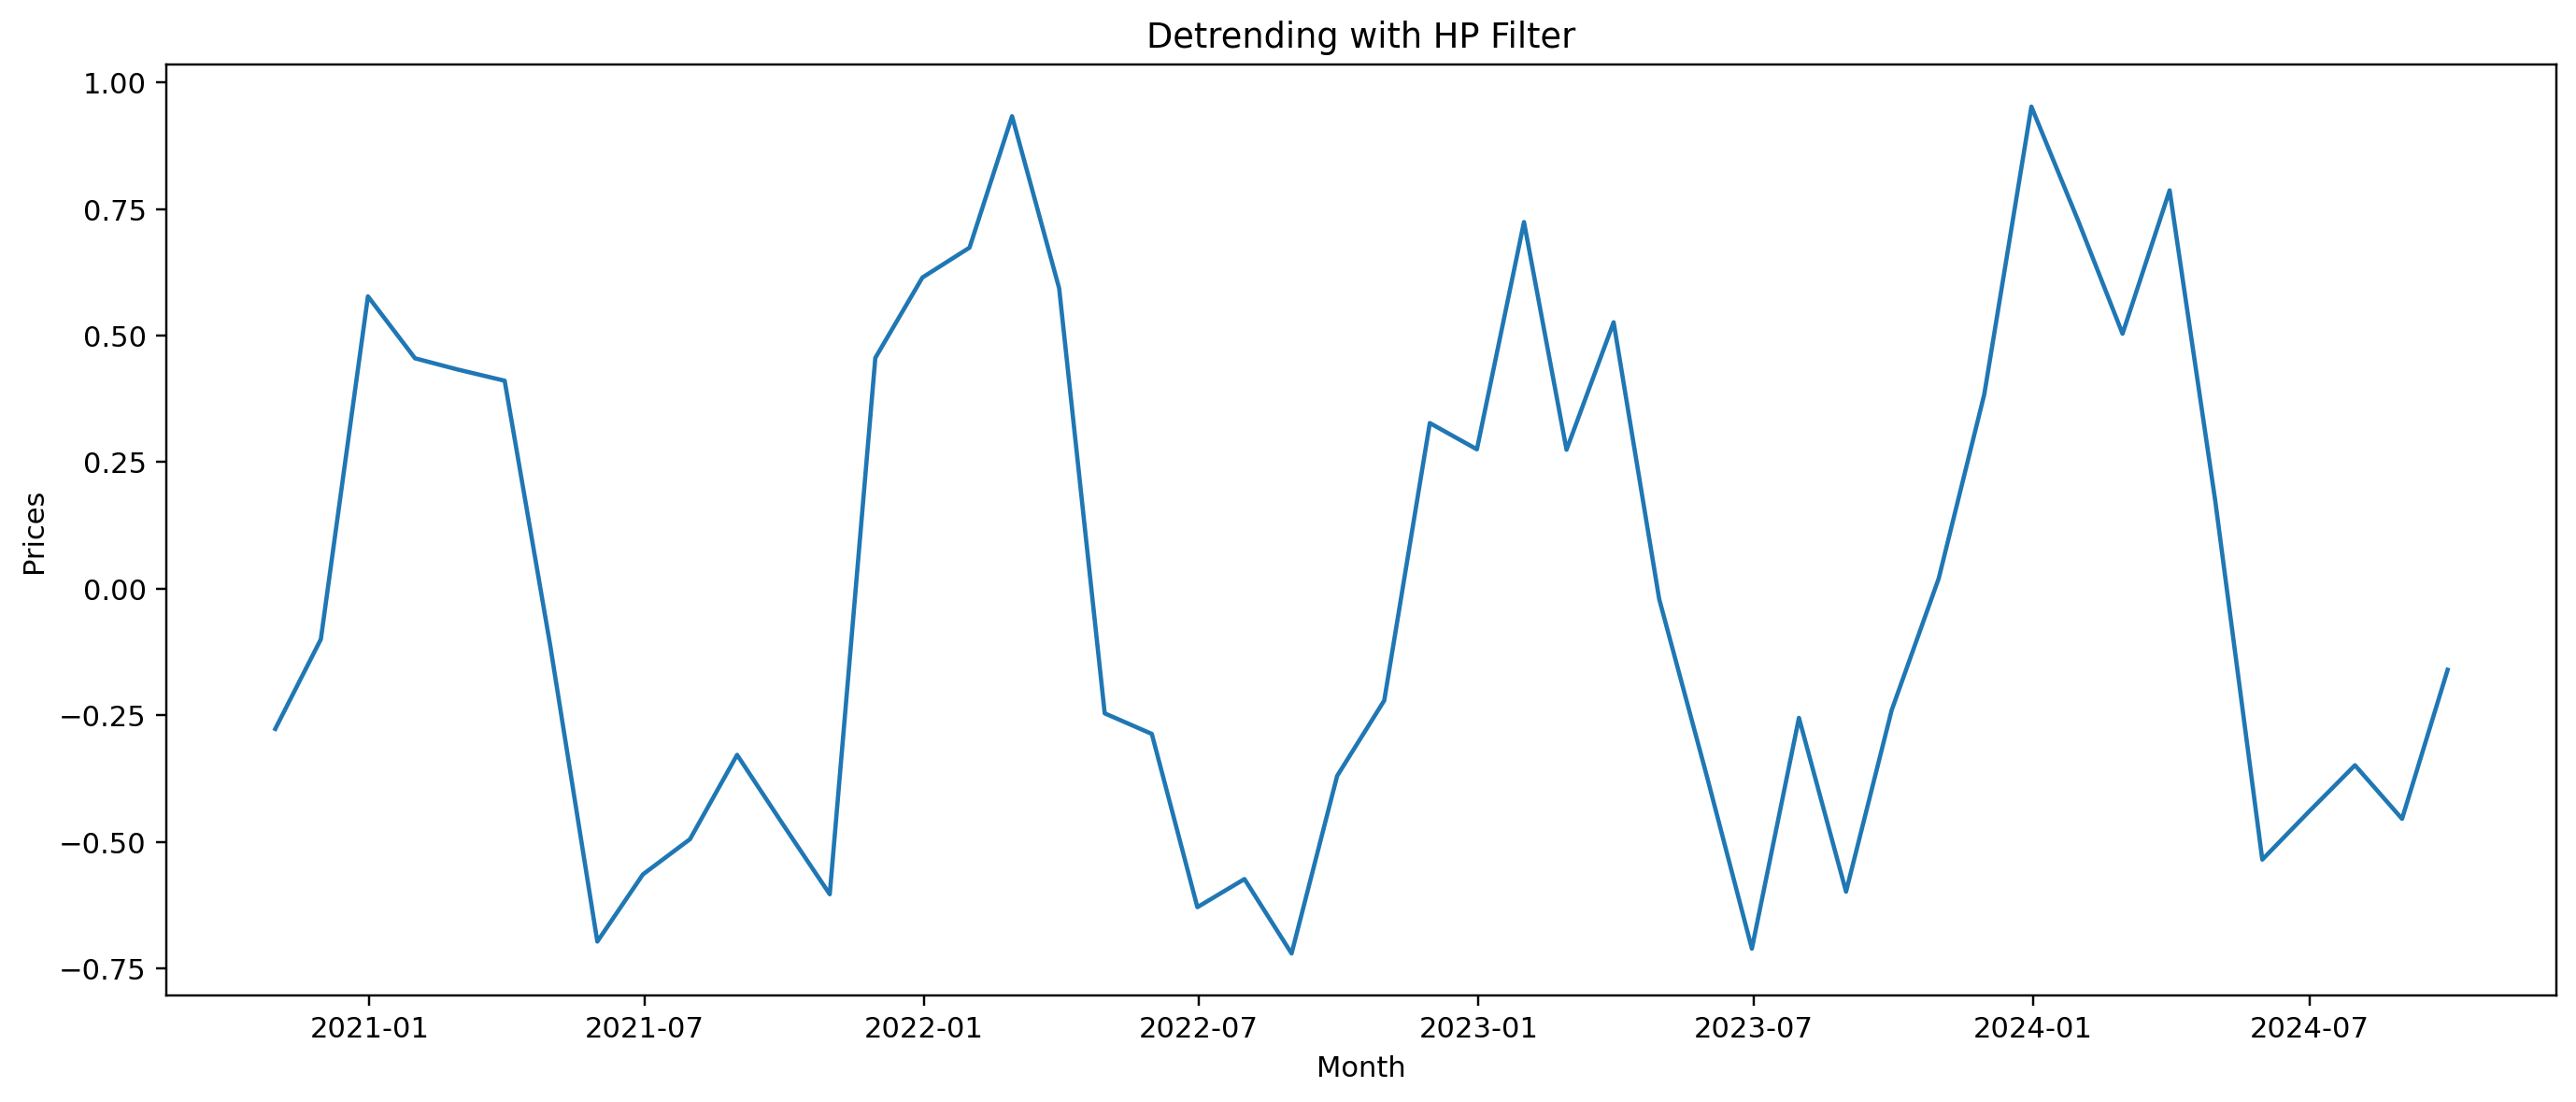

In [59]:
#hp filter; removing short term fluctuations
warnings.filterwarnings("ignore")
df_t = df.copy()

df_t["Trend"] = price_trend
detrended_hp = df_t.Prices - df_t.Trend

plt.figure(figsize=(15,6))
plt.plot(detrended_hp)
plt.title("Detrending with HP Filter")
plt.xlabel("Month")
plt.ylabel("Prices")
plt.show()

### HP Filter
The HP Filter is used in macroconomics to separate a *time series Yt* based on the long term **trend component** gt, and short term **cyclical component** ct.

* The method of HP Filter is  optimization and smoothing.

* The trend type is flexible because it is controlled by the lambda, and it is determined by the user.

* A smooth, flexible trend line has been subtracted from the data.

* Still have the same lenght as the series.

* The core concept of decomposition here is to separate the trend component and cyclical component. This means that HP Filter method tries to minimize residuals to trend gt to be close to the original time series Yt and minimize the change in growth rate; the trend should be smooth and not follow the ups and downs in the short term fluctuations.

It should be used for macroeconomic analysis or business cycle isolation.


## Seasonality

Seasonality is a periodical fluctuation that the same pattern occurs at a regular basis. Its one of the characteristics of economic and stock prices data.

#### Detecting Seasonality

We have 2 ways to detect seasonality :

* Multiple box plots : It an essential graph to depict data out over a range.

* Autocorrelation plots : It is used to check the randomness of the data.



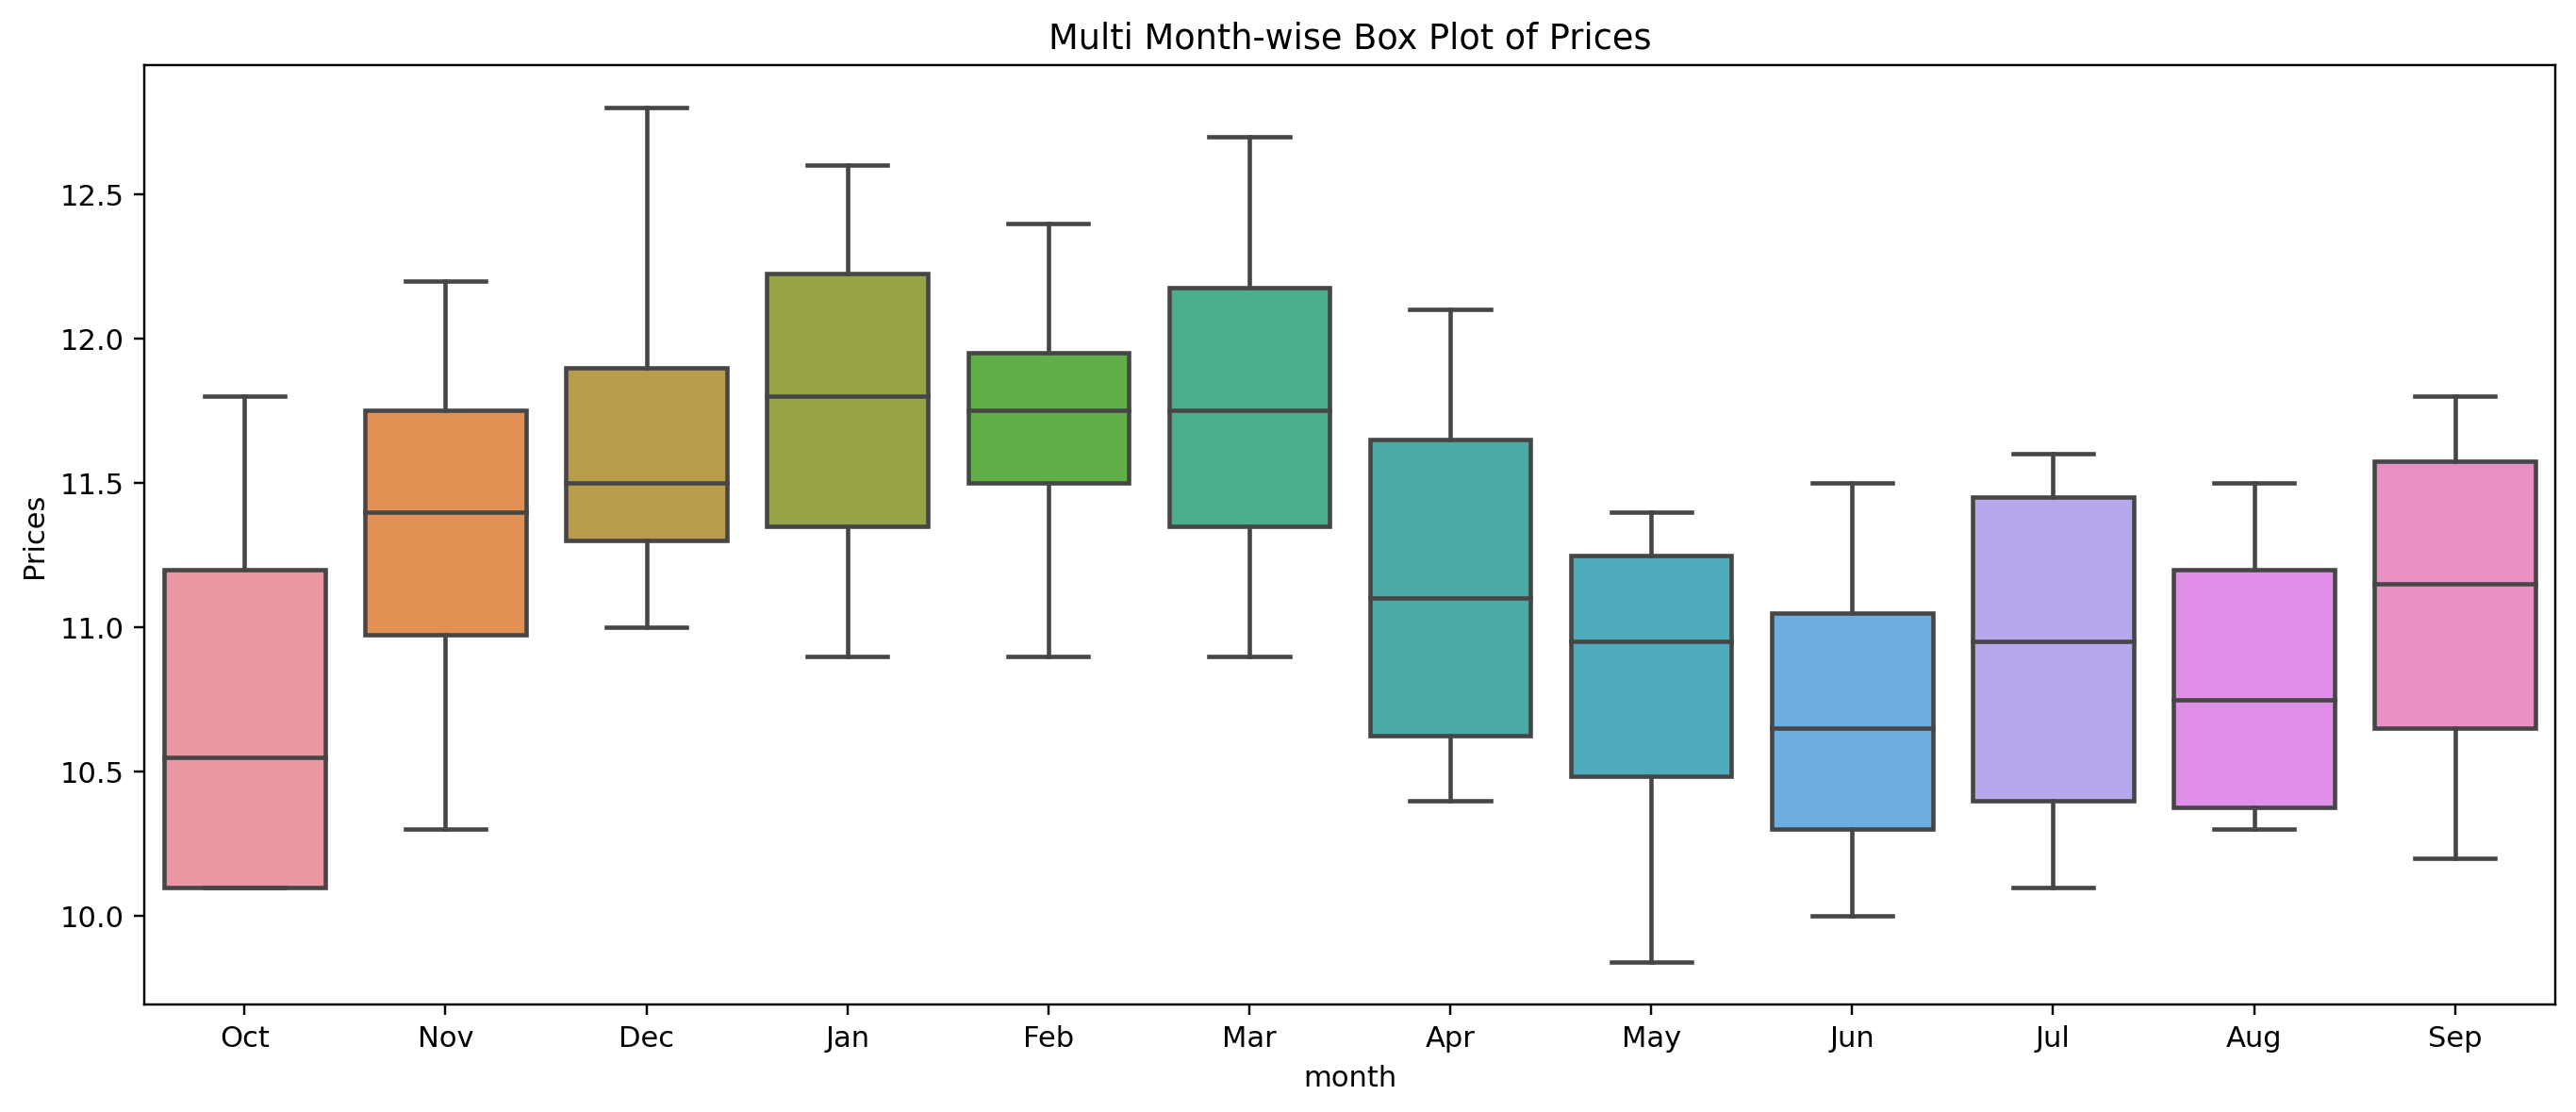

In [60]:
#detecting seasonality with multiple box plots

import seaborn as sns

df_bp = df.copy()

df_bp["month"] = df_bp.index.strftime("%b")

plt.figure(figsize = (15,6))

sns.boxplot(x="month",y = "Prices",data = df_bp)

plt.title("Multi Month-wise Box Plot of Prices")

plt.show()

Above the plot shows us there is high chance of data has seasonality. It was a little bit obvious because as I pointed out before the stock prices data has seasonality.

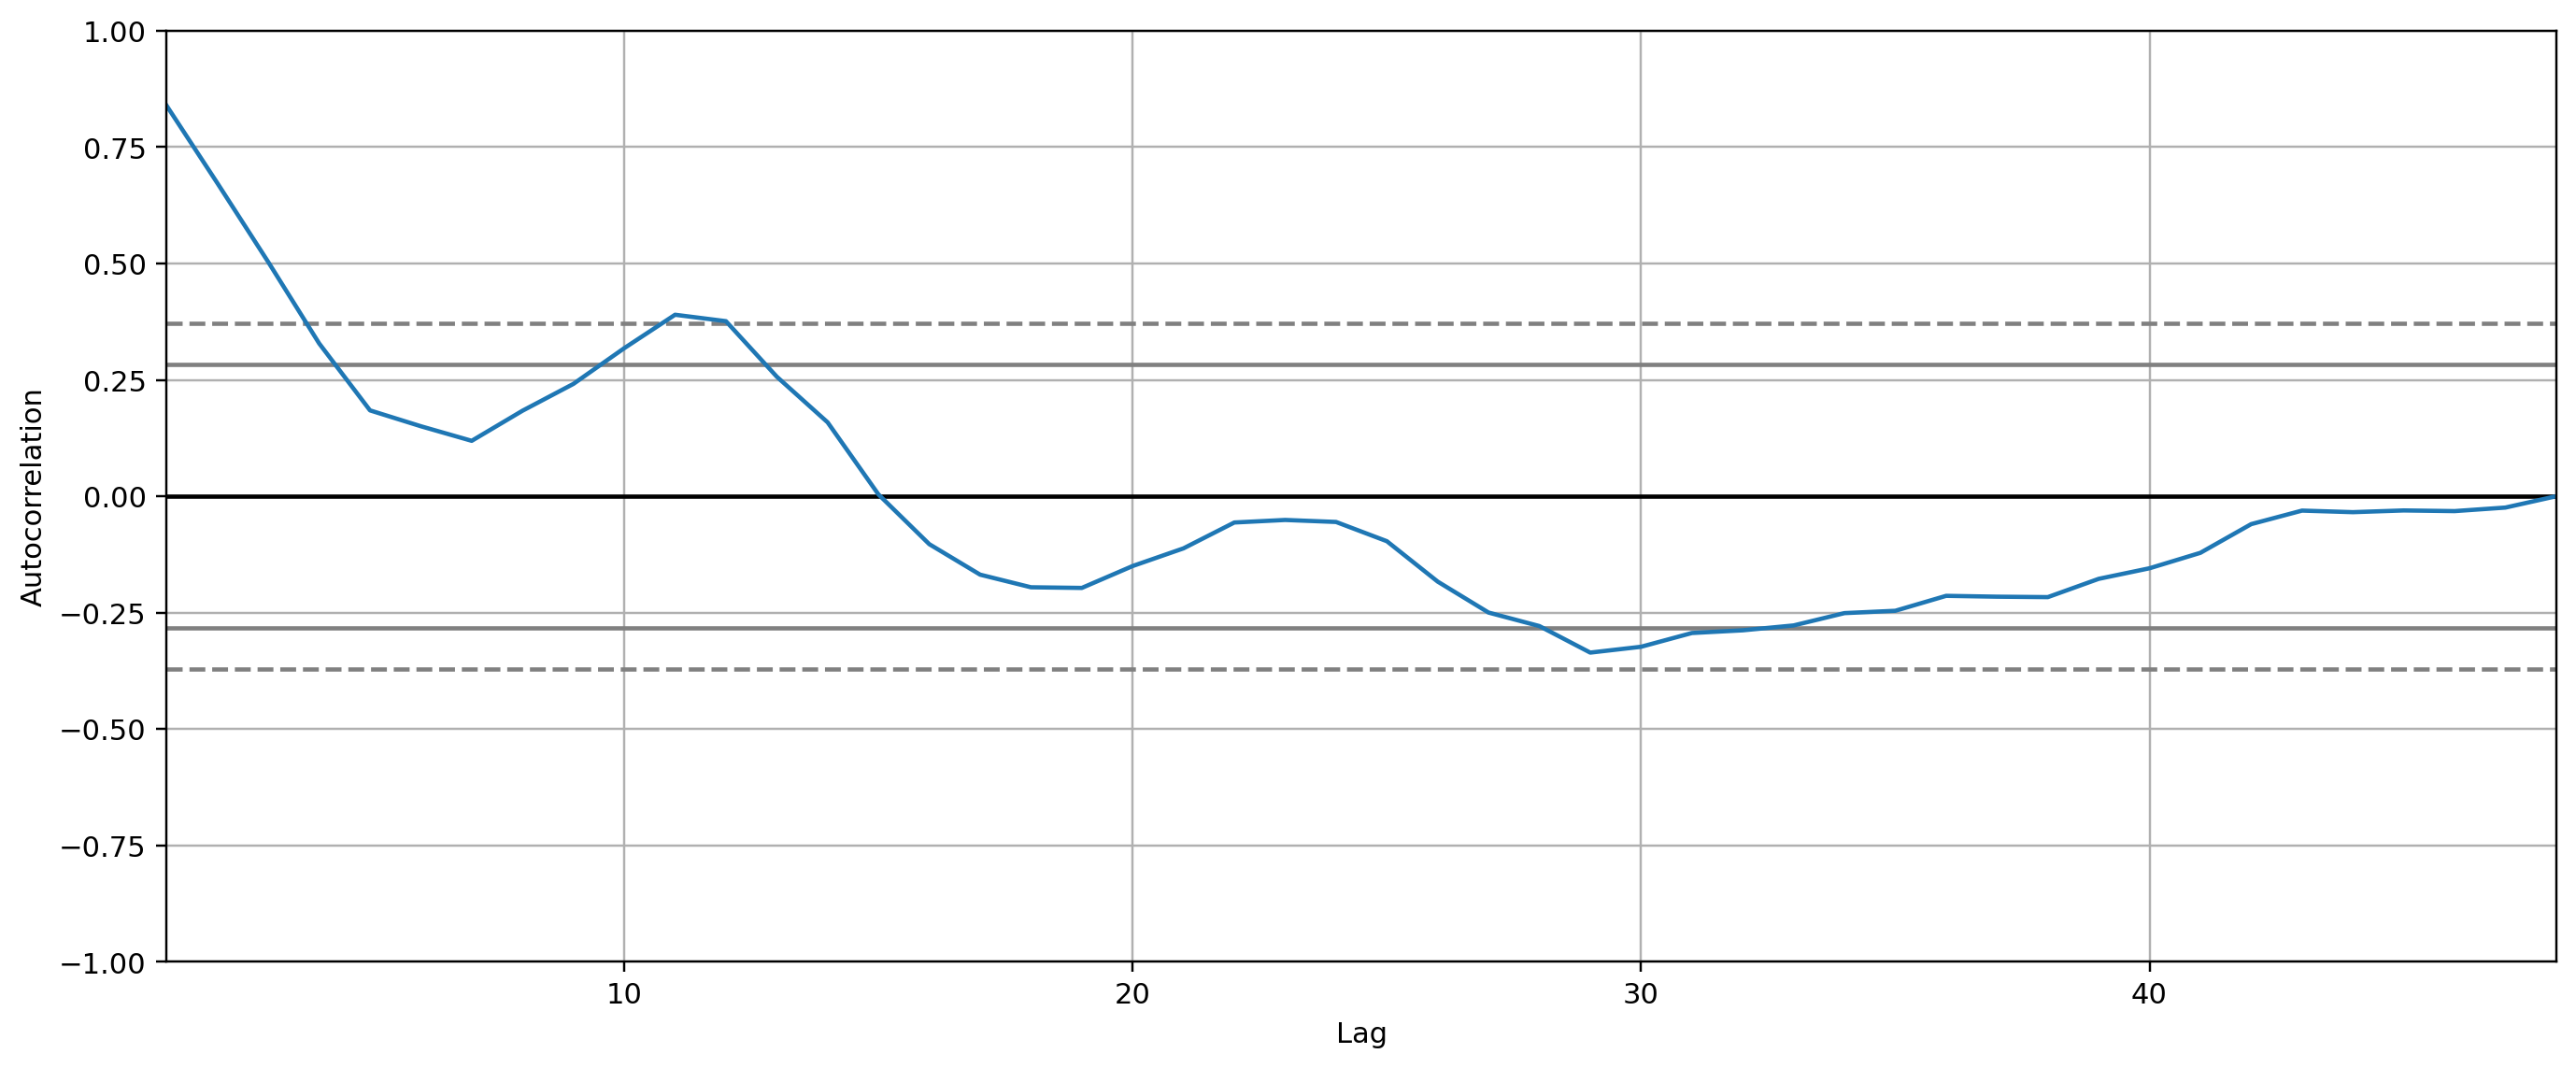

In [61]:
#autocorrelation plot to detect seasonality
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({"figure.figsize":(15,6),"figure.dpi":220})
autocorrelation_plot(df.Prices.tolist())
plt.show()

In ACF (Autocorrelation Function), there should be a smooth decrease, from where I can see that it is not decreasing. Actually its decreasing but there is so many ups and downs. A proper ACF should be a gradually decreasing plot. So we are sure that we have seasonality in our data. This strong autocorrelation also shows us our data is non-stationary. We can't use ARIMA models with that and for the sake of our research we shouldn't use ML models too. We have to fix it.

## Seasonal Decomposition

We will remove seasonality from the data by decompostion. It is the process of understanding generalizations and problems related to time-series forecasting.

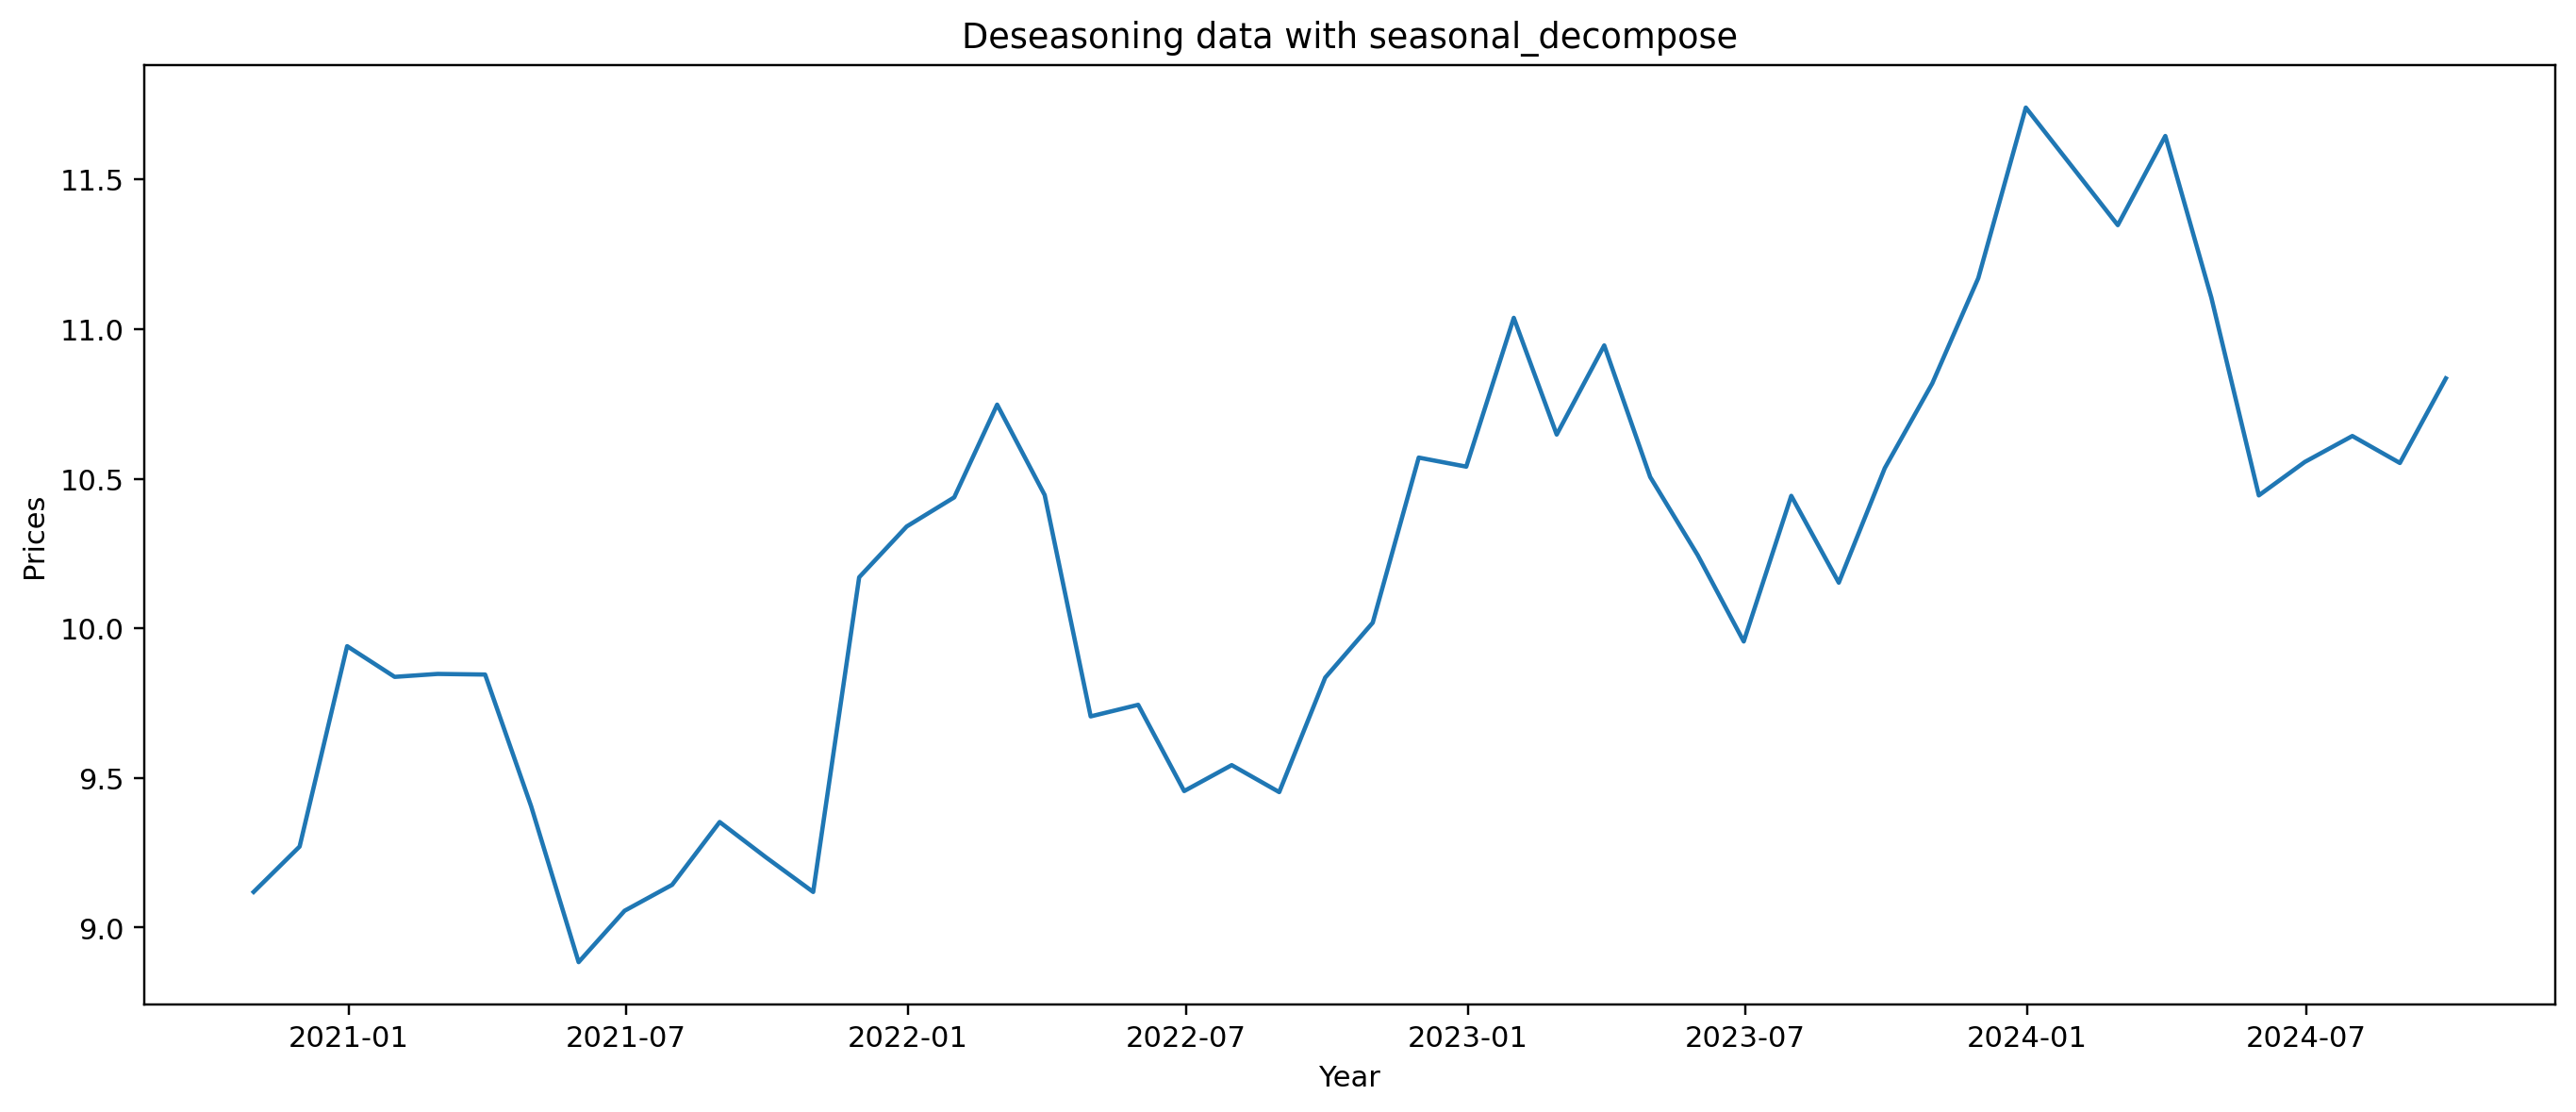

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

resul_mul = seasonal_decompose(df["Prices"],
                              model = "multiplicative",
                              extrapolate_trend="freq",)

deseason = df["Prices"] - resul_mul.seasonal

plt.figure(figsize = (15,6))
plt.plot(deseason)
plt.title("Deseasoning data with seasonal_decompose")
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

Here, I am free of seasoning but now I am where I was at the beginning. There is a trend, which is also ruining stationarity. So I will used the code above with one difference; which is I am gonna use it with pandas .diff function.

In [63]:
df_diff = pd.DataFrame(diff)
df_diff.dropna()
df_diff.head()

,Prices
Dates,
2020-10-31,NaN
2020-11-30,0.2
2020-12-31,0.7
2021-01-31,-0.1
2021-02-28,0.0


In [64]:
diff_clean = diff.dropna()
diff_clean.head()

Dates
2020-11-30    0.2
2020-12-31    0.7
2021-01-31   -0.1
2021-02-28    0.0
2021-03-31    0.0
Name: Prices, dtype: float64

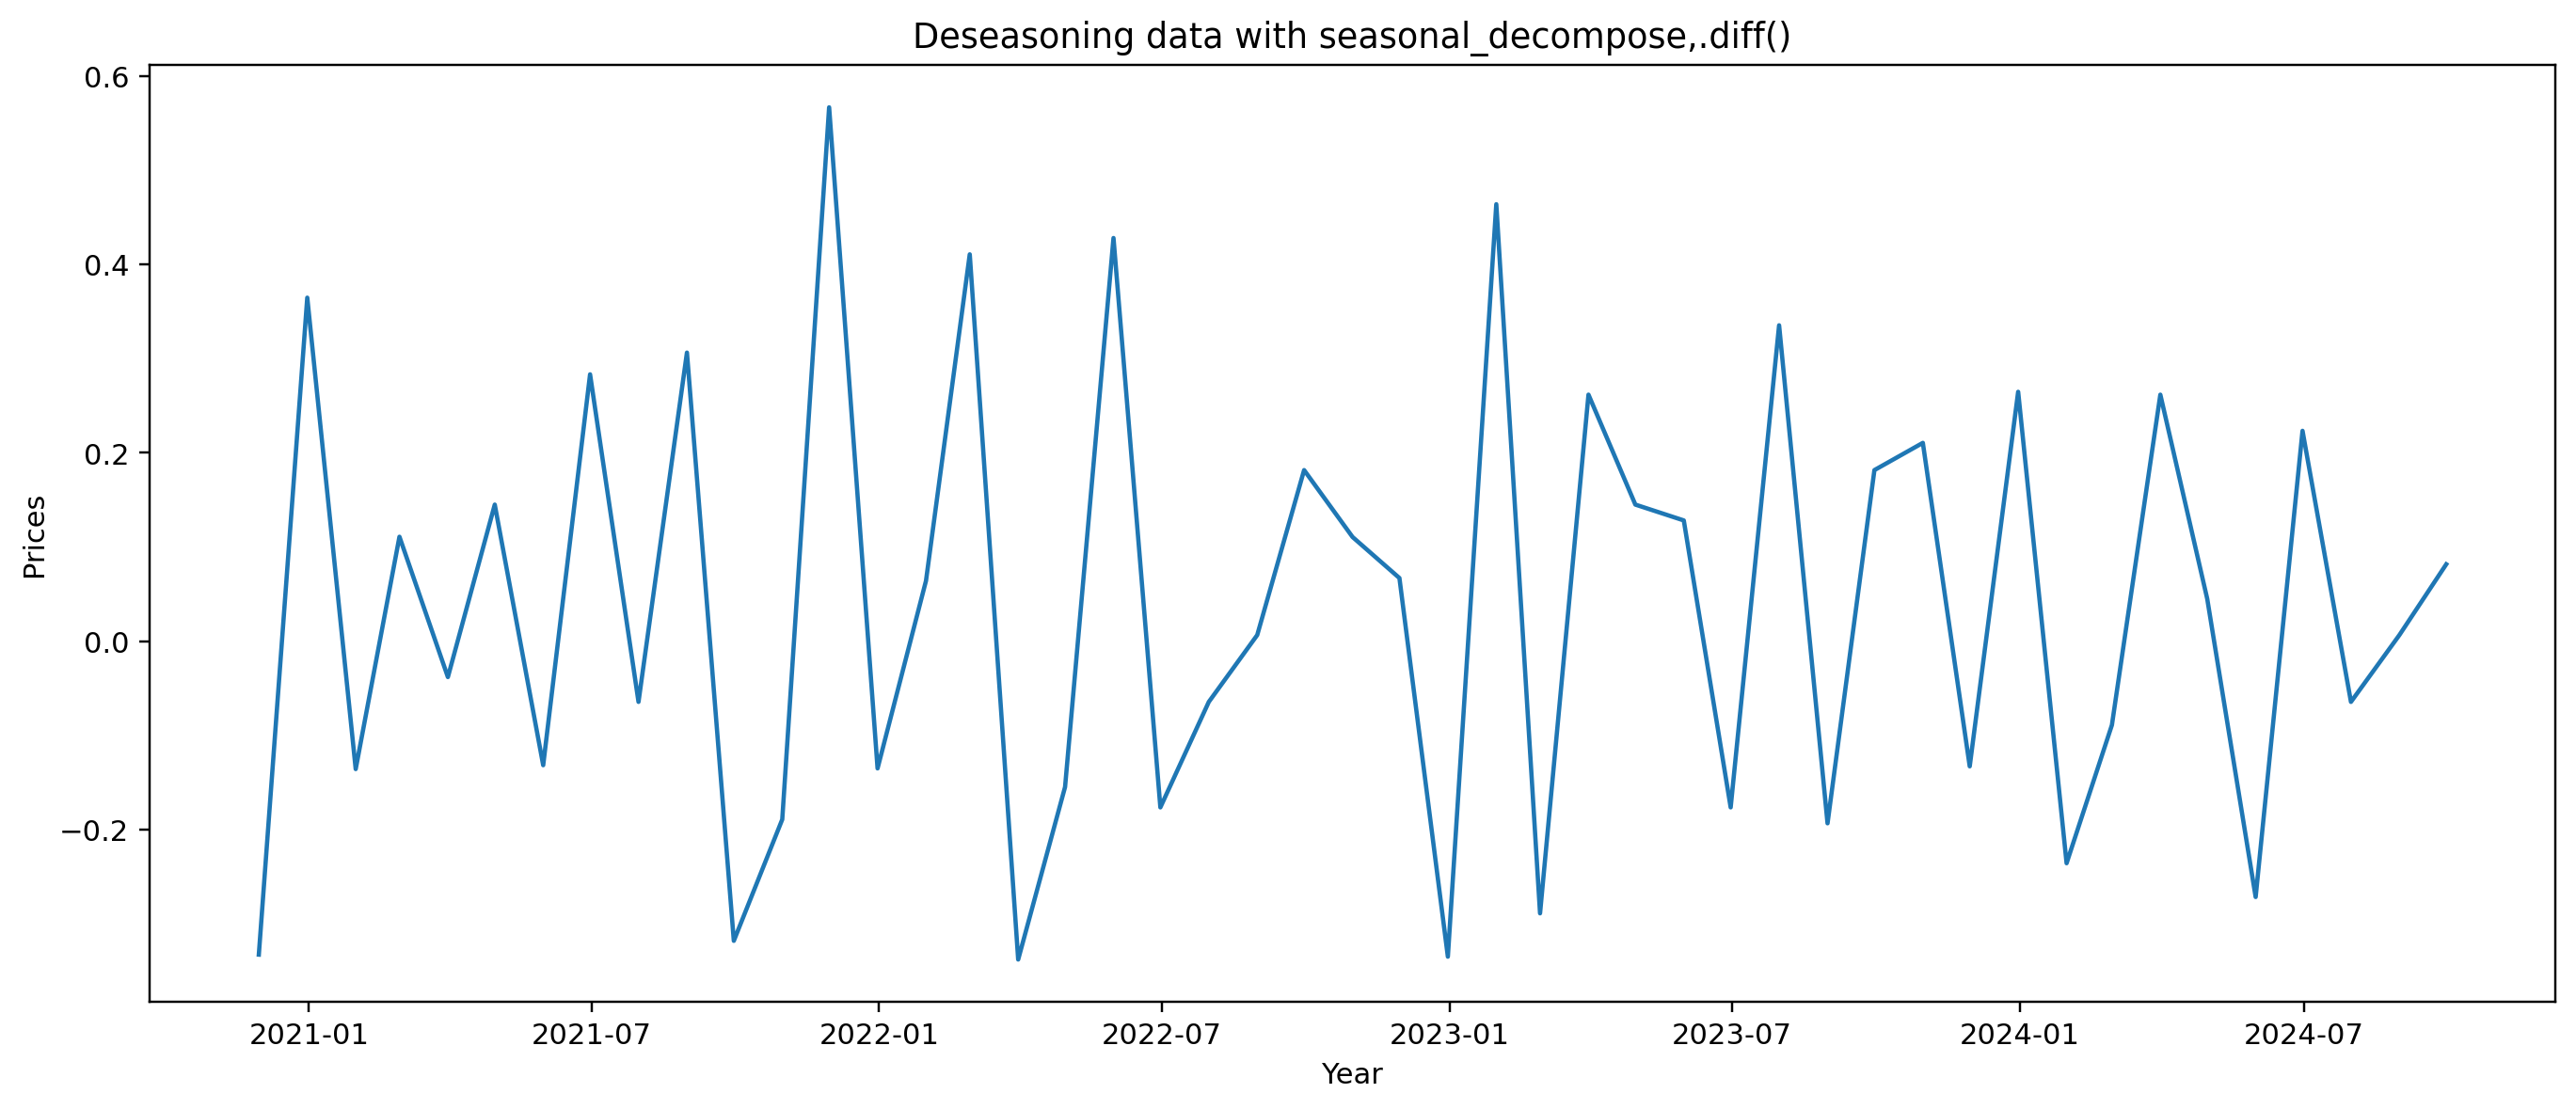

In [65]:
#without seasonality and trends

result_mul_pandas = seasonal_decompose(diff_clean,
                                      model = "additive",
                                      extrapolate_trend=12)

deseason_pandas = df_diff["Prices"] - result_mul_pandas.seasonal

plt.figure(figsize = (15,6))
plt.plot(deseason_pandas)
plt.title("Deseasoning data with seasonal_decompose,.diff()")
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

Well, now I see a  good plot. But the problem here that we have negative values. But still our data do not suffer from trends or seasonality. I changed the model parameter to additive because if I have a multiplicative model there shouldn't be any negative or zero values. I will now use the same thing for SciPy signal.detrend(), because this one is for the ARIMA models. SciPy is for ML and regression models.

In [66]:
detrended_sp

array([-0.19027211, -0.02928535,  0.6317014 ,  0.49268816,  0.45367492,
        0.41466167, -0.12435157, -0.72336481, -0.60237806, -0.5413913 ,
       -0.38040454, -0.51941779, -0.65843103,  0.40255572,  0.56354248,
        0.62452924,  0.88551599,  0.54650275, -0.29251049, -0.33152374,
       -0.67053698, -0.60955022, -0.74856347, -0.38757671, -0.22658996,
        0.3343968 ,  0.29538356,  0.75637031,  0.31735707,  0.57834383,
        0.03933058, -0.29968266, -0.6386959 , -0.17770915, -0.51672239,
       -0.15573563,  0.10525112,  0.46623788,  1.02722463,  0.78821139,
        0.54919815,  0.8101849 ,  0.17117166, -0.56784158, -0.50685483,
       -0.44586807, -0.58488131, -0.32389456])

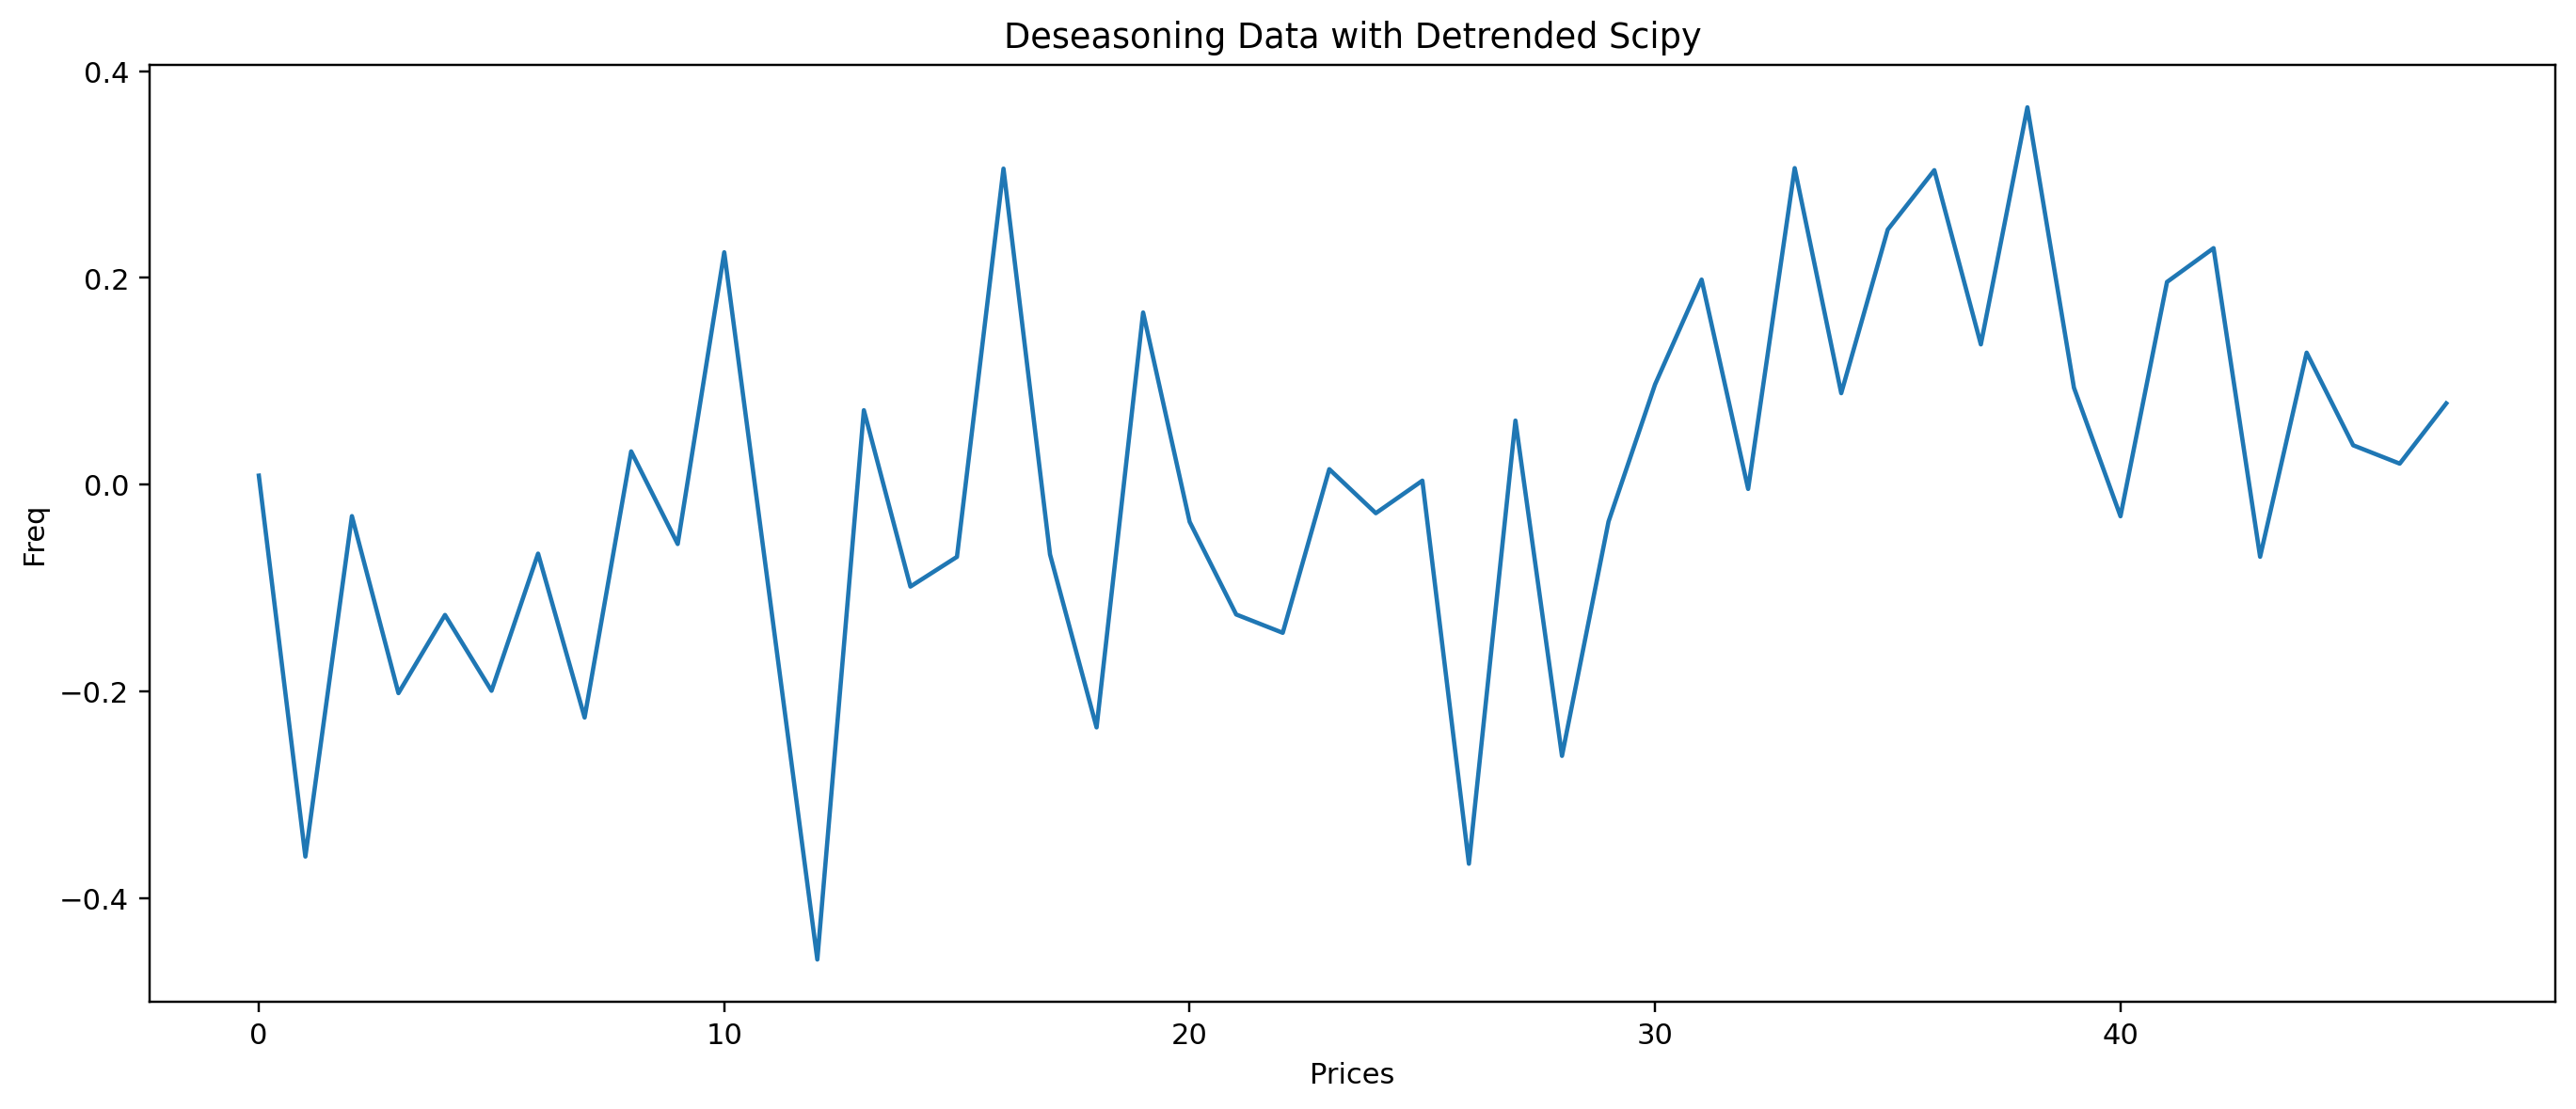

In [67]:
#deseasoning with SciPy detrend function-> getting rid of stationarity 

result_mul_scipy = seasonal_decompose(detrended_sp,
                                     model="additive",
                                     extrapolate_trend="freq",
                                     period=12)
deseason_scipy = detrended_sp - result_mul_scipy.seasonal

plt.figure(figsize = (15,6))
plt.plot(deseason_scipy)
plt.title("Deseasoning Data with Detrended Scipy")
plt.xlabel("Prices")
plt.ylabel("Freq")
plt.show()

Here I come to conclusion that using pandas .diff() function is way much better than the SciPy signal.detrend(). Because SciPy's plot does not looks as good as like pandas. I still feel that the mean is not same in everywhere, which causes non-stationarity. 

In [68]:
df_deseason_pd = pd.DataFrame(deseason_pandas)


df_deseason_pd.rename(columns = {0 : "Prices"},inplace=True)

df_deseason_pd.head()

,Prices
Dates,
2020-10-31,NaN
2020-11-30,-0.332937
2020-12-31,0.364874
2021-01-31,-0.135856
2021-02-28,0.110914


## Smoothing

### What is Smoothing?

Smoothing methods are statistical techniques to remove random fluctuations or irregularities to reveal the underlying patterns, trends, and cycles more clearly. There are a few ways of smoothing as follows :

* **Moving Average / Rolling Mean** : This is the simplest method where each data point is replaced by the average of a fixed number of neighboor data points. It gives equal weight in each observation. While Simple Moving Average uses past observations, Centered Moving Average uses points before and after the observation. Best time to use it to remove the short-term fluctuations and identifiying trends when there is no significant trend or seasonality. In our data we both suffer from trends and seasonality so we wont be using this type.


* **Exponential Smoothing** : It gives less weight to older data points and more weight to new data points. It is more responsive to the new data. So financial or stock data can be a good example. There is three types of Exponential Smoothing:

    * *Simple Exponential Smoothing (SES)* : Used when data has no trends or seasonal patterns. It involves a parameter    called alpha, the smoothing parameter. The core idea here is to employ a weighted moving average including exponentially decreasing weights, so higher weights to most recent observations.
    
    * *Double Exponential Smoothing (Holt's Method)* : It s used when the data exhibits trend but not seasonality. This method adds a time trend equation in the formulation. We can adjust Holt's exponential smoothing forecast formula to capture either an additive or multiplicative trend.
    
    * *Triple Exponential Smoothing (Holt-Winters' Method)* : It is used when the data exhibits both trend and seasonality. The Winter Method uses the idea of Holt Method and adds seasonality. It is a forecasting method that enforces exponential smoothing three times.  

In [69]:
#now I will try 3 types of exponential smoothing

from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

X = df["Prices"]

test = X.iloc[-10:] #getting the 20% of the data for testing
train = X.iloc[:-10] #getting the 80% of the data for training

#now i will create a function that has all evaluation metrics like MSE, MAE,RMSE,MAPE and R-Square

def time_series_evaluation_metrics_f(y_true,y_pred):
    def mean_absolute_percentage_error(y_true,y_pred):
        y_true,y_pred = np.array(y_true),np.array(y_pred)
        return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
    print("Evaluation metric results:-")
    print(f"MSE is : {mean_squared_error(y_true,y_pred)}")
    print(f"MAE is : {mean_absolute_error(y_true,y_pred)}")
    print(f"RMSE is : {np.sqrt(mean_squared_error(y_true,y_pred))}")
    print(f"MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}")
    print(f"R2 is : {r2_score(y_true,y_pred)}",end = "\n\n")
    

In [70]:
resu = []
temp_df = pd.DataFrame()

for i in [0,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1]:
    print(f"Fitting for smoothing level = {i}")
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    fcst_pred_v = fit_v.forecast(10)
    time_series_evaluation_metrics_f(test,fcst_pred_v)
    rmse = np.sqrt(mean_squared_error(test,fcst_pred_v))
    df3 = {"smoothing parameter": i, "RMSE":rmse}
    temp_df = temp_df.append(df3,ignore_index=True)

temp_df.sort_values(by=["RMSE"]).head(3)

Fitting for smoothing level = 0
Evaluation metric results:-
MSE is : 1.3773255038312726
MAE is : 1.052105272219122
RMSE is : 1.1735951192090366
MAPE is : 8.569175584235337
R2 is : -4.0936594076600334

Fitting for smoothing level = 0.1
Evaluation metric results:-
MSE is : 0.7113320499913949
MAE is : 0.6640271455229785
RMSE is : 0.8434050331788369
MAPE is : 5.339957982446388
R2 is : -1.6306658653527921

Fitting for smoothing level = 0.2
Evaluation metric results:-
MSE is : 0.4799624273223103
MAE is : 0.5271119558400533
RMSE is : 0.6927932067524265
MAPE is : 4.229431594309722
R2 is : -0.7750089767836925

Fitting for smoothing level = 0.3
Evaluation metric results:-
MSE is : 0.39016165637232897
MAE is : 0.5012131942254738
RMSE is : 0.6246292151127171
MAPE is : 4.046369166648546
R2 is : -0.44290553392133525

Fitting for smoothing level = 0.4
Evaluation metric results:-
MSE is : 0.3314510838060232
MAE is : 0.48141703504097483
RMSE is : 0.5757178856054614
MAPE is : 3.9113330809446305
R2 is : 

,smoothing parameter,RMSE
7,0.7,0.520013
8,0.8,0.524065
6,0.6,0.524565


In [71]:
fitSES = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level=0.1,optimized=False) 
fctgs_gs_pred = fitSES.forecast(10)
time_series_evaluation_metrics_f(test,fctgs_gs_pred)

Evaluation metric results:-
MSE is : 0.7246405034373594
MAE is : 0.6739736667239749
RMSE is : 0.8512581884700784
MAPE is : 5.422723485393618
R2 is : -1.6798835186292882



In [72]:
fitSES_auto = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level=0.1,optimized=True,use_brute=True) 
#optimized -> estimates the model parameters by maximizing the log likelihood..
#use_brute -> searching for good starting values
fctgs_auto_pred = fitSES_auto.forecast(10)
time_series_evaluation_metrics_f(test,fctgs_auto_pred)

Evaluation metric results:-
MSE is : 0.7113320499913949
MAE is : 0.6640271455229785
RMSE is : 0.8434050331788369
MAPE is : 5.339957982446388
R2 is : -1.6306658653527921



In [73]:
fitSES_auto.summary()

Dep. Variable:,endog,No. Observations:,38
Model:,SimpleExpSmoothing,SSE,12.397
Optimized:,True,AIC,-38.564
Trend:,None,BIC,-35.289
Seasonal:,None,AICC,-37.352
Seasonal Periods:,None,Date:,"Sun, 23 Nov 2025"
Box-Cox:,False,Time:,15:19:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
initial_level,10.645074,l.0,True


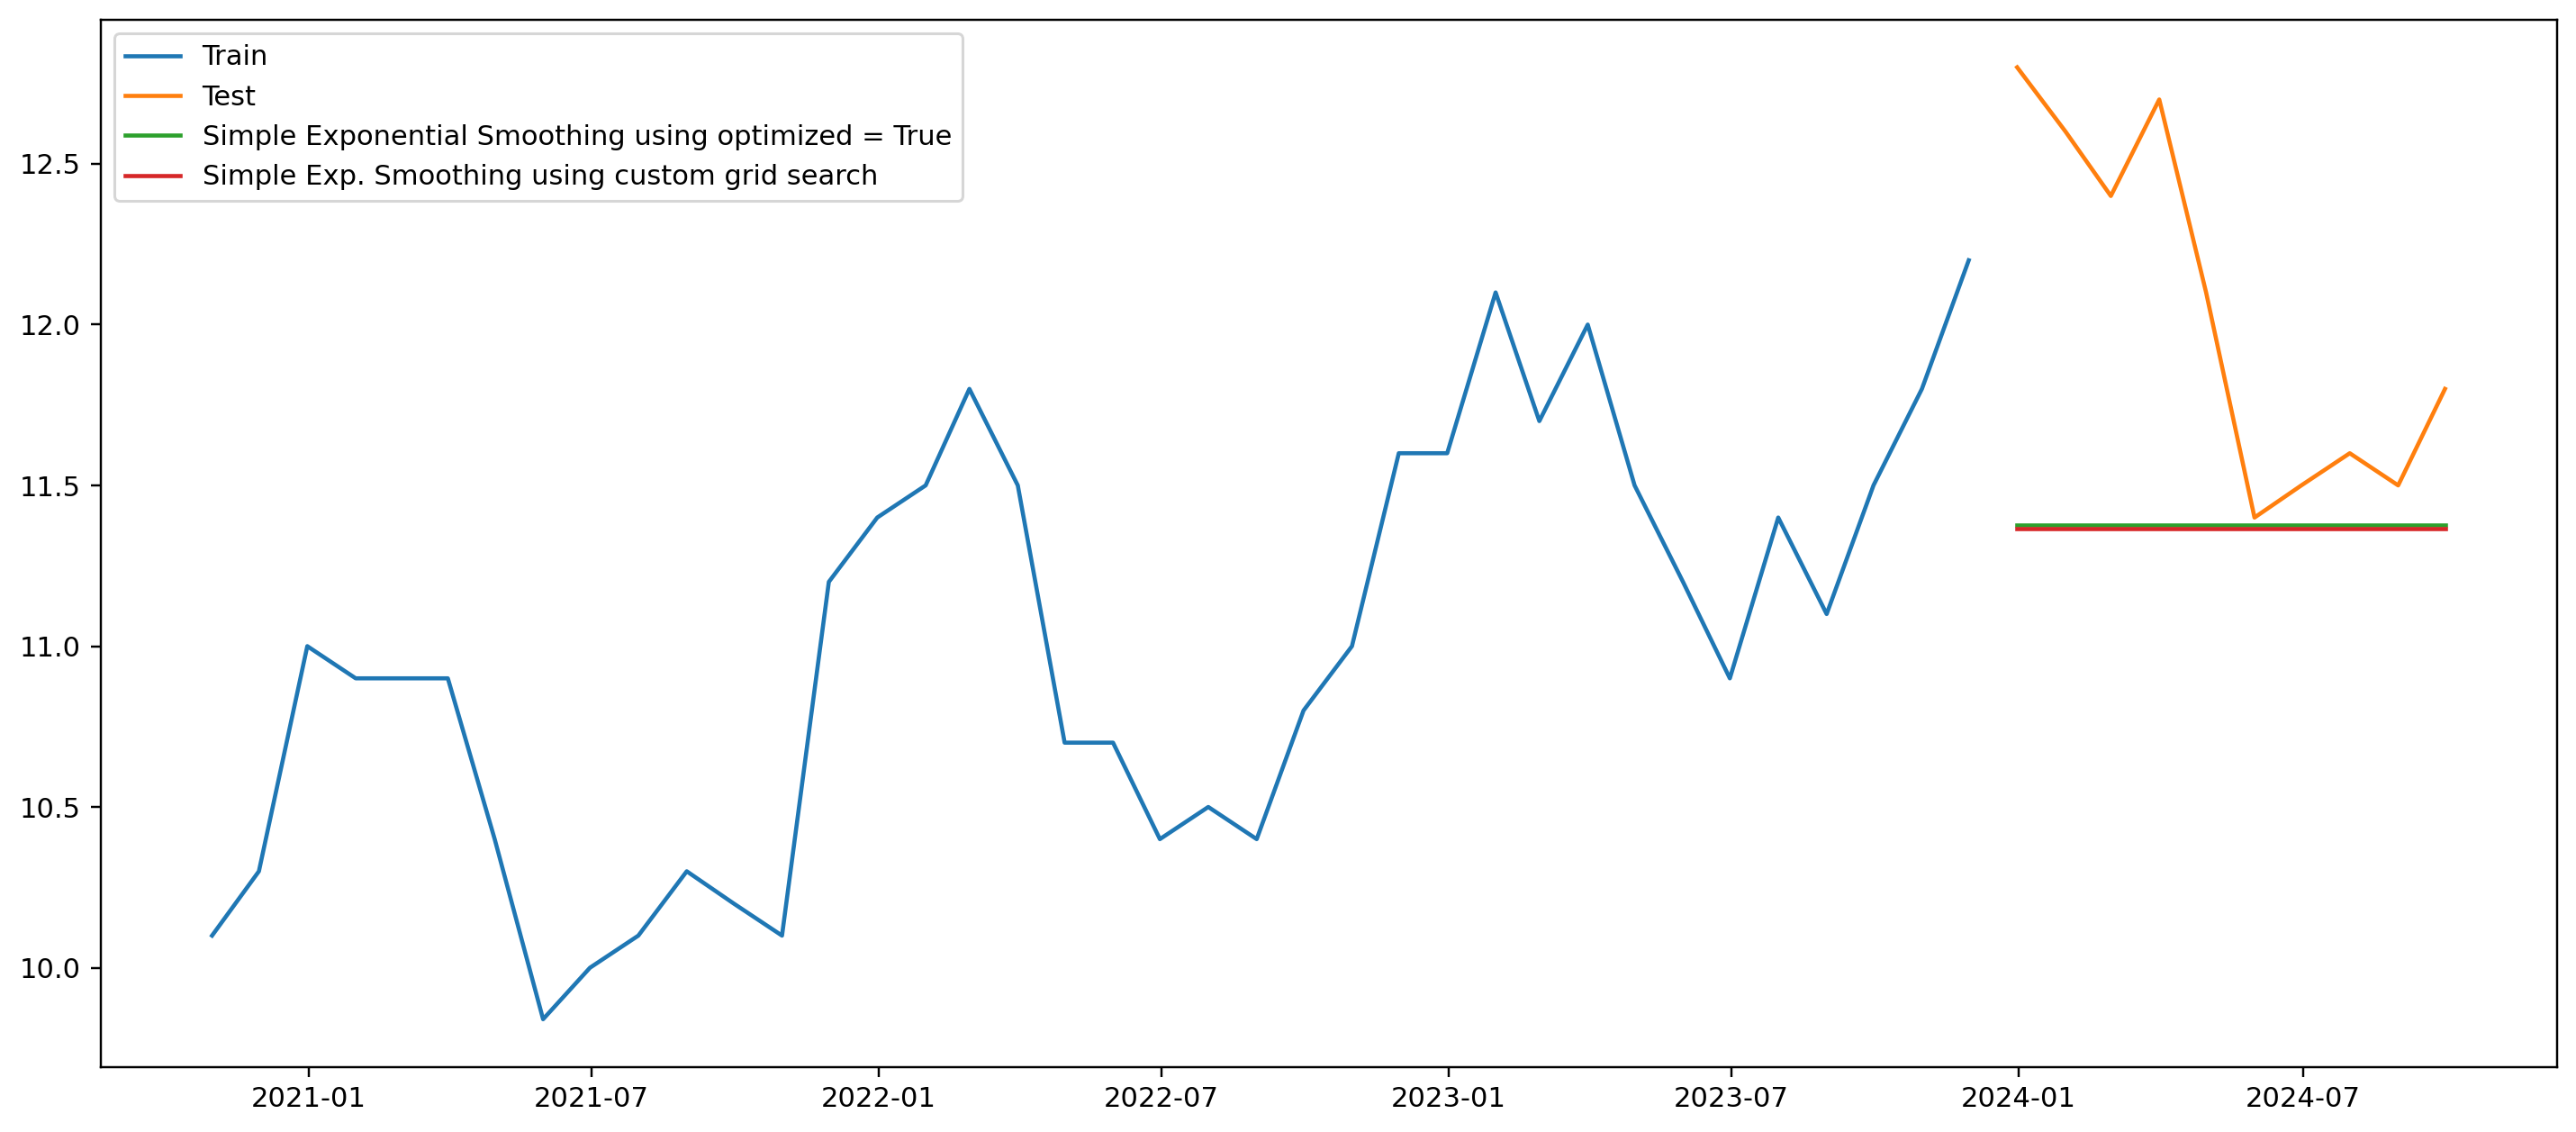

In [74]:
#plotting 

test_index = test.index

fctgs_gs_pred_series = pd.Series(fctgs_gs_pred, index=test_index)
fctgs_auto_pred_series = pd.Series(fctgs_auto_pred, index=test_index)


plt.figure(figsize = (16,7))

plt.plot(train,label = "Train")
plt.plot(test,label = "Test")
plt.plot(fctgs_auto_pred_series,label = "Simple Exponential Smoothing using optimized = True")
plt.plot(fctgs_gs_pred_series,label = "Simple Exp. Smoothing using custom grid search")
plt.legend(loc = "best")
plt.show()

Because my data has both seasonality and trend, I have kind of a busted plot. Because SES models assume that my data do not suffer seasonality nor trend. But even in the plot I can see an upward trend and also high volatility around same date points.The model here is SES basically sees an average level at the end of the data, which are the yellow and red lines.I need to change this to Holt-Winter's Method.

**Exponential Smoothing Parameter** means that as it get more close to 1, then the weight of last observations are higher. Here we see that top 3 parameters are very close to 1. Lower RMSE belongs to the alpha = 0.7, so we should give higher weight to the latest observations. Now we will also loook for DES(Holt's Method) and TES(Holt-Winter's Method).

In [75]:
## Holt-Winter's Method

from sklearn import metrics

from timeit import default_timer as timer

from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.holtwinters import ExponentialSmoothing

param_grid = {"trend":["add"],"seasonal":["add"],"seasonal_periods":[3,6,12],
              "smoothing_level":[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1],
             "smoothing_slope":[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1],
             "damping_slope":[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1],
             "damped":[True,False],"use_boxcox":[True,False],"remove_bias":[True,False],
             "use_basinhopping":[True,False],
             "smoothing_seasonal":[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1]}

pg = list(ParameterGrid(param_grid))

df_results = pd.DataFrame(columns=["trend","seasonal_periods","smoothing_level","smoothing_slope","damping_slope",
                                  "damped","use_boxcox","remove_bias","use_basinhopping","RMSE","r2"])

start = timer()

print("Start Grid Search..")

for a,b in enumerate(pg):
    trend = b.get("trend")
    smoothing_level = b.get("smoothing_level")
    seasonal_periods = b.get("seasonal_periods")
    smoothing_level = b.get("smoothing_level")
    smoothing_slope = b.get("smoothing_slope")
    smoothing_seasonal = b.get("smoothing_seasonal")
    damping_slope = b.get("damping_slope")
    damped = b.get("damped")
    use_boxcox = b.get("use_boxcox")
    remove_bias = b.get("remove_bias")
    use_basinhopping = b.get("use_basinhopping")


fit1 = ExponentialSmoothing(train,trend=trend,damped = damped,
                            seasonal_periods = seasonal_periods,
                            use_boxcox = use_boxcox).fit(smoothing_level=smoothing_level,
                                                         smoothing_seasonal=smoothing_seasonal,
                                                         damping_slope = damping_slope,
                                                         smoothing_slope=smoothing_slope,
                                                         optimized = False)

z= fit1.forecast(10)

df_pred = pd.DataFrame(z,columns = ["Forecasted_result"])
RMSE = np.sqrt(mean_squared_error(test,df_pred.Forecasted_result))
r2 = r2_score(test,df_pred.Forecasted_result)
df_results = df_results.append({"trend":trend,
                                         "seasonal_periods":seasonal_periods,
                                         "smoothing_level":smoothing_level,
                                         "smoothing_slope":smoothing_slope,
                                         "damping_slope":damping_slope,
                                         "damped":damped,
                                         "use_boxcox":use_boxcox,
                                         "use_basinhopping":use_basinhopping,
                                         "RMSE":RMSE,
                                         "r2":r2},ignore_index=True)

print("End of Grid Search")

end = timer()

print(f"Total Time taken to complete grid search in seconds:{(end-start)}")

print(f"Below mentioned parameter gives least RMSE and r2")
df_results.sort_values(by=["RMSE","r2"]).head(1)

Start Grid Search..
End of Grid Search
Total Time taken to complete grid search in seconds:1.138951500004623
Below mentioned parameter gives least RMSE and r2


,trend,seasonal_periods,smoothing_level,smoothing_slope,damping_slope,damped,use_boxcox,remove_bias,use_basinhopping,RMSE,r2
0,add,12,1,1,1,False,False,NaN,False,2.856571,-29.177515


In [76]:

fit_1 = ExponentialSmoothing(train,trend = "add",damped=False,seasonal_periods=12).fit(smoothing_level=1,
                                                                              smoothing_slope = 1,
                                                                              damping_slope=1,
                                                                              #use_boxcox=False,
                                                                              #use_basinhopping= False,
                                                                              optimized=False)
forecast_custom_pred = fit_1.forecast(10)

fit_1.summary()
time_series_evaluation_metrics_f(test,forecast_custom_pred)


Evaluation metric results:-
MSE is : 8.159999999999945
MAE is : 2.3999999999999924
RMSE is : 2.8565713714171306
MAPE is : 20.476142720528955
R2 is : -29.177514792899213



### ALERT!!

Here, I don't even need to do plotting because R2 is negative which means even a dummy regression is better than what we have here. So I think Holt-Winters' method is not the one we have been looking for. 

Because of this I am going to use Double Exponential Smoothing, also known as Holt's Method. Maybe our data suffer from trends and not so much of seasonality.

In [77]:
from statsmodels.tsa.api import Holt

param_grid_holt = {"smoothing_level":[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90],
                  "smoothing_slope":[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90],
                  "damping_slope":[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90],
                  "damped":[True,False]}
pg_holt = list(ParameterGrid(param_grid_holt))

df_results_holt = pd.DataFrame(columns=["smoothing_level","smoothing_slope","damping_slope",
                                       "damped","RMSE","r2"])

start = timer()

for a,b in enumerate(pg_holt):
    smoothing_level = b.get("smoothing_level")
    smoothing_slope = b.get("smoothing_slope")
    damping_slope = b.get("damping_slope")
    damped = b.get("damped")
    print(smoothing_level,smoothing_slope,damping_slope,damped)
    fit_holt = Holt(train,damped=damped).fit(smoothing_level=smoothing_level,
                                            smoothing_slope=smoothing_slope,
                                            damping_slope=damping_slope,
                                            optimized=False)
    z_holt = fit_holt.forecast(10)
    #print(z_holt)
    df_pred_holt = pd.DataFrame(z,columns=["Forecasted_result_holt"])
    RMSE = np.sqrt(mean_squared_error(test,df_pred_holt.Forecasted_result_holt))
    r2 = r2_score(test,df_pred_holt.Forecasted_result_holt)
    print(f"RMSE is {RMSE}")
    df_results_holt = df_results_holt.append({"smoothing_level":smoothing_level,
                                             "smoothing_slope":smoothing_slope,
                                             "damping_slope":damping_slope,
                                             "damped":damped,
                                             "RMSE":RMSE,
                                             "r2":r2},ignore_index=True)

end = timer()

print(f"Total time taken to complete grid search in seconds:{(end-start)}")
print(f"Below mentioned parameters gives least RMSE and r2")
df_results_holt.sort_values(by=["RMSE","r2"]).head(1)
    
    

0.1 0.1 0.1 True
RMSE is 2.8565713714171306
0.1 0.2 0.1 True
RMSE is 2.8565713714171306
0.1 0.3 0.1 True
RMSE is 2.8565713714171306
0.1 0.4 0.1 True
RMSE is 2.8565713714171306
0.1 0.5 0.1 True
RMSE is 2.8565713714171306
0.1 0.6 0.1 True
RMSE is 2.8565713714171306
0.1 0.7 0.1 True
RMSE is 2.8565713714171306
0.1 0.8 0.1 True
RMSE is 2.8565713714171306
0.1 0.9 0.1 True
RMSE is 2.8565713714171306
0.2 0.1 0.1 True
RMSE is 2.8565713714171306
0.2 0.2 0.1 True
RMSE is 2.8565713714171306
0.2 0.3 0.1 True
RMSE is 2.8565713714171306
0.2 0.4 0.1 True
RMSE is 2.8565713714171306
0.2 0.5 0.1 True
RMSE is 2.8565713714171306
0.2 0.6 0.1 True
RMSE is 2.8565713714171306
0.2 0.7 0.1 True
RMSE is 2.8565713714171306
0.2 0.8 0.1 True
RMSE is 2.8565713714171306
0.2 0.9 0.1 True
RMSE is 2.8565713714171306
0.3 0.1 0.1 True
RMSE is 2.8565713714171306
0.3 0.2 0.1 True
RMSE is 2.8565713714171306
0.3 0.3 0.1 True
RMSE is 2.8565713714171306
0.3 0.4 0.1 True
RMSE is 2.8565713714171306
0.3 0.5 0.1 True
RMSE is 2.85657

RMSE is 2.8565713714171306
0.3 0.8 0.3 True
RMSE is 2.8565713714171306
0.3 0.9 0.3 True
RMSE is 2.8565713714171306
0.4 0.1 0.3 True
RMSE is 2.8565713714171306
0.4 0.2 0.3 True
RMSE is 2.8565713714171306
0.4 0.3 0.3 True
RMSE is 2.8565713714171306
0.4 0.4 0.3 True
RMSE is 2.8565713714171306
0.4 0.5 0.3 True
RMSE is 2.8565713714171306
0.4 0.6 0.3 True
RMSE is 2.8565713714171306
0.4 0.7 0.3 True
RMSE is 2.8565713714171306
0.4 0.8 0.3 True
RMSE is 2.8565713714171306
0.4 0.9 0.3 True
RMSE is 2.8565713714171306
0.5 0.1 0.3 True
RMSE is 2.8565713714171306
0.5 0.2 0.3 True
RMSE is 2.8565713714171306
0.5 0.3 0.3 True
RMSE is 2.8565713714171306
0.5 0.4 0.3 True
RMSE is 2.8565713714171306
0.5 0.5 0.3 True
RMSE is 2.8565713714171306
0.5 0.6 0.3 True
RMSE is 2.8565713714171306
0.5 0.7 0.3 True
RMSE is 2.8565713714171306
0.5 0.8 0.3 True
RMSE is 2.8565713714171306
0.5 0.9 0.3 True
RMSE is 2.8565713714171306
0.6 0.1 0.3 True
RMSE is 2.8565713714171306
0.6 0.2 0.3 True
RMSE is 2.8565713714171306
0.6 0

RMSE is 2.8565713714171306
0.6 0.8 0.5 True
RMSE is 2.8565713714171306
0.6 0.9 0.5 True
RMSE is 2.8565713714171306
0.7 0.1 0.5 True
RMSE is 2.8565713714171306
0.7 0.2 0.5 True
RMSE is 2.8565713714171306
0.7 0.3 0.5 True
RMSE is 2.8565713714171306
0.7 0.4 0.5 True
RMSE is 2.8565713714171306
0.7 0.5 0.5 True
RMSE is 2.8565713714171306
0.7 0.6 0.5 True
RMSE is 2.8565713714171306
0.7 0.7 0.5 True
RMSE is 2.8565713714171306
0.7 0.8 0.5 True
RMSE is 2.8565713714171306
0.7 0.9 0.5 True
RMSE is 2.8565713714171306
0.8 0.1 0.5 True
RMSE is 2.8565713714171306
0.8 0.2 0.5 True
RMSE is 2.8565713714171306
0.8 0.3 0.5 True
RMSE is 2.8565713714171306
0.8 0.4 0.5 True
RMSE is 2.8565713714171306
0.8 0.5 0.5 True
RMSE is 2.8565713714171306
0.8 0.6 0.5 True
RMSE is 2.8565713714171306
0.8 0.7 0.5 True
RMSE is 2.8565713714171306
0.8 0.8 0.5 True
RMSE is 2.8565713714171306
0.8 0.9 0.5 True
RMSE is 2.8565713714171306
0.9 0.1 0.5 True
RMSE is 2.8565713714171306
0.9 0.2 0.5 True
RMSE is 2.8565713714171306
0.9 0

0.9 0.6 0.7 True
RMSE is 2.8565713714171306
0.9 0.7 0.7 True
RMSE is 2.8565713714171306
0.9 0.8 0.7 True
RMSE is 2.8565713714171306
0.9 0.9 0.7 True
RMSE is 2.8565713714171306
0.1 0.1 0.8 True
RMSE is 2.8565713714171306
0.1 0.2 0.8 True
RMSE is 2.8565713714171306
0.1 0.3 0.8 True
RMSE is 2.8565713714171306
0.1 0.4 0.8 True
RMSE is 2.8565713714171306
0.1 0.5 0.8 True
RMSE is 2.8565713714171306
0.1 0.6 0.8 True
RMSE is 2.8565713714171306
0.1 0.7 0.8 True
RMSE is 2.8565713714171306
0.1 0.8 0.8 True
RMSE is 2.8565713714171306
0.1 0.9 0.8 True
RMSE is 2.8565713714171306
0.2 0.1 0.8 True
RMSE is 2.8565713714171306
0.2 0.2 0.8 True
RMSE is 2.8565713714171306
0.2 0.3 0.8 True
RMSE is 2.8565713714171306
0.2 0.4 0.8 True
RMSE is 2.8565713714171306
0.2 0.5 0.8 True
RMSE is 2.8565713714171306
0.2 0.6 0.8 True
RMSE is 2.8565713714171306
0.2 0.7 0.8 True
RMSE is 2.8565713714171306
0.2 0.8 0.8 True
RMSE is 2.8565713714171306
0.2 0.9 0.8 True
RMSE is 2.8565713714171306
0.3 0.1 0.8 True
RMSE is 2.85657

RMSE is 2.8565713714171306
0.3 0.7 0.1 False
RMSE is 2.8565713714171306
0.3 0.8 0.1 False
RMSE is 2.8565713714171306
0.3 0.9 0.1 False
RMSE is 2.8565713714171306
0.4 0.1 0.1 False
RMSE is 2.8565713714171306
0.4 0.2 0.1 False
RMSE is 2.8565713714171306
0.4 0.3 0.1 False
RMSE is 2.8565713714171306
0.4 0.4 0.1 False
RMSE is 2.8565713714171306
0.4 0.5 0.1 False
RMSE is 2.8565713714171306
0.4 0.6 0.1 False
RMSE is 2.8565713714171306
0.4 0.7 0.1 False
RMSE is 2.8565713714171306
0.4 0.8 0.1 False
RMSE is 2.8565713714171306
0.4 0.9 0.1 False
RMSE is 2.8565713714171306
0.5 0.1 0.1 False
RMSE is 2.8565713714171306
0.5 0.2 0.1 False
RMSE is 2.8565713714171306
0.5 0.3 0.1 False
RMSE is 2.8565713714171306
0.5 0.4 0.1 False
RMSE is 2.8565713714171306
0.5 0.5 0.1 False
RMSE is 2.8565713714171306
0.5 0.6 0.1 False
RMSE is 2.8565713714171306
0.5 0.7 0.1 False
RMSE is 2.8565713714171306
0.5 0.8 0.1 False
RMSE is 2.8565713714171306
0.5 0.9 0.1 False
RMSE is 2.8565713714171306
0.6 0.1 0.1 False
RMSE is 2.

RMSE is 2.8565713714171306
0.6 0.1 0.3 False
RMSE is 2.8565713714171306
0.6 0.2 0.3 False
RMSE is 2.8565713714171306
0.6 0.3 0.3 False
RMSE is 2.8565713714171306
0.6 0.4 0.3 False
RMSE is 2.8565713714171306
0.6 0.5 0.3 False
RMSE is 2.8565713714171306
0.6 0.6 0.3 False
RMSE is 2.8565713714171306
0.6 0.7 0.3 False
RMSE is 2.8565713714171306
0.6 0.8 0.3 False
RMSE is 2.8565713714171306
0.6 0.9 0.3 False
RMSE is 2.8565713714171306
0.7 0.1 0.3 False
RMSE is 2.8565713714171306
0.7 0.2 0.3 False
RMSE is 2.8565713714171306
0.7 0.3 0.3 False
RMSE is 2.8565713714171306
0.7 0.4 0.3 False
RMSE is 2.8565713714171306
0.7 0.5 0.3 False
RMSE is 2.8565713714171306
0.7 0.6 0.3 False
RMSE is 2.8565713714171306
0.7 0.7 0.3 False
RMSE is 2.8565713714171306
0.7 0.8 0.3 False
RMSE is 2.8565713714171306
0.7 0.9 0.3 False
RMSE is 2.8565713714171306
0.8 0.1 0.3 False
RMSE is 2.8565713714171306
0.8 0.2 0.3 False
RMSE is 2.8565713714171306
0.8 0.3 0.3 False
RMSE is 2.8565713714171306
0.8 0.4 0.3 False
RMSE is 2.

RMSE is 2.8565713714171306
0.8 0.7 0.5 False
RMSE is 2.8565713714171306
0.8 0.8 0.5 False
RMSE is 2.8565713714171306
0.8 0.9 0.5 False
RMSE is 2.8565713714171306
0.9 0.1 0.5 False
RMSE is 2.8565713714171306
0.9 0.2 0.5 False
RMSE is 2.8565713714171306
0.9 0.3 0.5 False
RMSE is 2.8565713714171306
0.9 0.4 0.5 False
RMSE is 2.8565713714171306
0.9 0.5 0.5 False
RMSE is 2.8565713714171306
0.9 0.6 0.5 False
RMSE is 2.8565713714171306
0.9 0.7 0.5 False
RMSE is 2.8565713714171306
0.9 0.8 0.5 False
RMSE is 2.8565713714171306
0.9 0.9 0.5 False
RMSE is 2.8565713714171306
0.1 0.1 0.6 False
RMSE is 2.8565713714171306
0.1 0.2 0.6 False
RMSE is 2.8565713714171306
0.1 0.3 0.6 False
RMSE is 2.8565713714171306
0.1 0.4 0.6 False
RMSE is 2.8565713714171306
0.1 0.5 0.6 False
RMSE is 2.8565713714171306
0.1 0.6 0.6 False
RMSE is 2.8565713714171306
0.1 0.7 0.6 False
RMSE is 2.8565713714171306
0.1 0.8 0.6 False
RMSE is 2.8565713714171306
0.1 0.9 0.6 False
RMSE is 2.8565713714171306
0.2 0.1 0.6 False
RMSE is 2.

RMSE is 2.8565713714171306
0.1 0.9 0.8 False
RMSE is 2.8565713714171306
0.2 0.1 0.8 False
RMSE is 2.8565713714171306
0.2 0.2 0.8 False
RMSE is 2.8565713714171306
0.2 0.3 0.8 False
RMSE is 2.8565713714171306
0.2 0.4 0.8 False
RMSE is 2.8565713714171306
0.2 0.5 0.8 False
RMSE is 2.8565713714171306
0.2 0.6 0.8 False
RMSE is 2.8565713714171306
0.2 0.7 0.8 False
RMSE is 2.8565713714171306
0.2 0.8 0.8 False
RMSE is 2.8565713714171306
0.2 0.9 0.8 False
RMSE is 2.8565713714171306
0.3 0.1 0.8 False
RMSE is 2.8565713714171306
0.3 0.2 0.8 False
RMSE is 2.8565713714171306
0.3 0.3 0.8 False
RMSE is 2.8565713714171306
0.3 0.4 0.8 False
RMSE is 2.8565713714171306
0.3 0.5 0.8 False
RMSE is 2.8565713714171306
0.3 0.6 0.8 False
RMSE is 2.8565713714171306
0.3 0.7 0.8 False
RMSE is 2.8565713714171306
0.3 0.8 0.8 False
RMSE is 2.8565713714171306
0.3 0.9 0.8 False
RMSE is 2.8565713714171306
0.4 0.1 0.8 False
RMSE is 2.8565713714171306
0.4 0.2 0.8 False
RMSE is 2.8565713714171306
0.4 0.3 0.8 False
RMSE is 2.

,smoothing_level,smoothing_slope,damping_slope,damped,RMSE,r2
0,0.1,0.1,0.1,True,2.856571,-29.177515


I am not going to do plotting, because there is a problem. The problem is I thought there was trend and seasonality in the data but more crucially there is stationarity exhibits in the data. 

#### Why do I have a negative r2?

r2 = 1- SSR(error of my model)/SST(error you would get simply by predicting the mean)

so when SSR > SST -> We have a negative r2. If your errors of exponential smoothing is larger than if you just draw a mean line.

And non-stationary is the culprit for poor data. Because of that we try to make it go away.

# STATIONARITY

Five types of stationary:

* **Strict or Strong Stationary** : It is the strongest form of stationarity in a time series data. If the joint probablity distribution of any collection does not change when we go forward or backward in time then we call it strict stationarity.

* **First-order Stationary** : It is a weak form of stationarity. When series has a constant mean that never changes over time. So its long-term average level never drifts uf or down. Other statistical properties like variance may be changing.

* **Weak (Second-order) Stationary** : Weak Stationary is important because there is three crucial things for us to predict/estimates properties of the process by averaging over time. First one is *constant mean*; the mean of the series do not change by time so we do not have a deterministic trend. Second one is *constant varience* ; which means the volatility of series is constant. This means that series is homoscedastic ; the volatility do not increase or decrease over time. The last one is *Constant autocovarience* which means the covarience of the any two points in the series depends on the time lag. So any tto points of covariance will be the same always.

* **Trend Stationarity** : It happens when the non-stationarity caused only by a deterministic trend component. Key idea here is we can make the series stationary basically by detrending; removing the predictiable linear or quadratic trend, wthout using differentiating.

* **Difference Stationarity** : This means that data sets which can be non-stationary by bas,cally applying differencing operation one time or more.


## Detecting Stationarity

There is 3 ways to determine stationarity:

* First way using **plots**. A plot that is not increasing or decreasing and shows constant growth over time is stationary time series.

* Second way is looking at **summary statistics**, We can look at the min,max,mean,std. deviation etc. to detect the behaviour of the data. But it is a little bit harder than looking at the plots.

* Third and much common way is to using unit root tests. There are 5 methods of those tests:

    * **Dickey-Fuller (DF) Test** : DF test is based on linear regression and serial correlation is a big issue. On the other hand ADF solves serial correlation and handles big and complex models. ADF Test'sprimary goal of it is to confirm a non-stationary time series data can be stationary by differencing. The null hypothesis is data has unit roots, which indicates that data is non-stationary. It is based on regressiong the first difference of time series data (delta Yt) on the lagged data (Yt-1). If the coefficient of lagged value is significantly negative then this means the series is stationary, in other words past values are a good predictor of change. If it is something like 0 then it suggest series has random walk,aka unit root.
    
    * **The Schmidt-Phillips Test** : It serves the same general purpose of ADF and Phillips Perron (PP) Test.The difference is the null hyphothesis of SPT is classified as a unit root test with a trend stationary. And the alternative hypothesis is data has unit root, which means we need differencng stationary.
    
    * **Phillips-Perron Test** : It is almost the same thing as ADF test, the difference is handling the autocorrelation. PP Test uses non-paramedic methods like correcting factor applied to test statistic. Unlike PP Test, ADF uses paramedic methods like lagged values. Also PP Test can handles heteroscedasticity, or complex autocorrelated data. 
    
    * **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test** : Key point of KPSS Test is that it reverses the null hypothesis compared to ADF and PP Tests. So the null hypothesis of KPSS test is that the time series is stationary. This reversal makes KPSS Test to a stationary test, while ADF and PP are unit root tests.
    
    
### Interpreting the P-value

* If the p-value is greater than 0.05, then we fail to reject H0.

* If the p-value is less than 0.05, we reject H0.

In ADF; if p-value > 0.05, we fail to reject H0, which is the null hypothesis of data has unit roots. So the time series is non-stationary. Hence, if p-value < 0.05 then we reject H0. So the time series is stationary and there is no unit roots exhibits in the data.

In KPSS ; if p-value > 0.05, we fail to reject H0, so the time series is statonary because the null hypothesis of KPSS test is time series is stationary. And we couldn't reject it. However if the p-value < 0.05 then we reject H0, which means the data is stationary. So in the case of p-value < 0.05 in KPSS test means that time series is non-stationary.



In [78]:
# now first we will look for if our data has stationary because of a unit root or because of 
#a unit root with trend stationary.

from statsmodels.tsa.stattools import adfuller

result = adfuller(df.values,regression="ct") # constant and trend

p_value = result[1]

print(f"ADF p-value :{p_value:.4f}")


ADF p-value :0.5693


p_value > 0.05 in this case, and our **null hypothesis is data has unit roots**, so it is not stationary. And we fail to reject this null hypothesis. So our data is stationary. So we will use ARIMA model;  the differenced data frame to see if its OK or not. 

In [79]:
df_diff = df_diff.dropna()
df_diff

result_1st_diff = adfuller(df_diff,regression="ct")

p_value_1st_diff = result_1st_diff[1]

print(f"ADF p-value :{p_value_1st_diff:.4f}")


ADF p-value :0.0000


After 1st differencing the p-value is 0, so now I reject H0. Differenciated data now is stationary and I can use ARIMA model to predict future prices. But I need to use acf and pacf plots to determine the ARIMA(p,q).

**Autoregressive (AR) Models:** Autoregressive basically means self-regressing. So it predicts the future behavior based on its past data. A crucial prerequesity for AR to work properly is data to be stationary.

**Moving Average (MA) Models:** Unline AR models, MA  models uses the relationship between observations and residuals. It trys to get all trends in the time series. 

**ACF Plots:** The correlation of a variable with its lagged values

**PACF Plots:** The correlation of a variable with its lagged values but after removing the effects of in-between time lags.

Text(0, 0.5, 'Partial Autocorrelation')

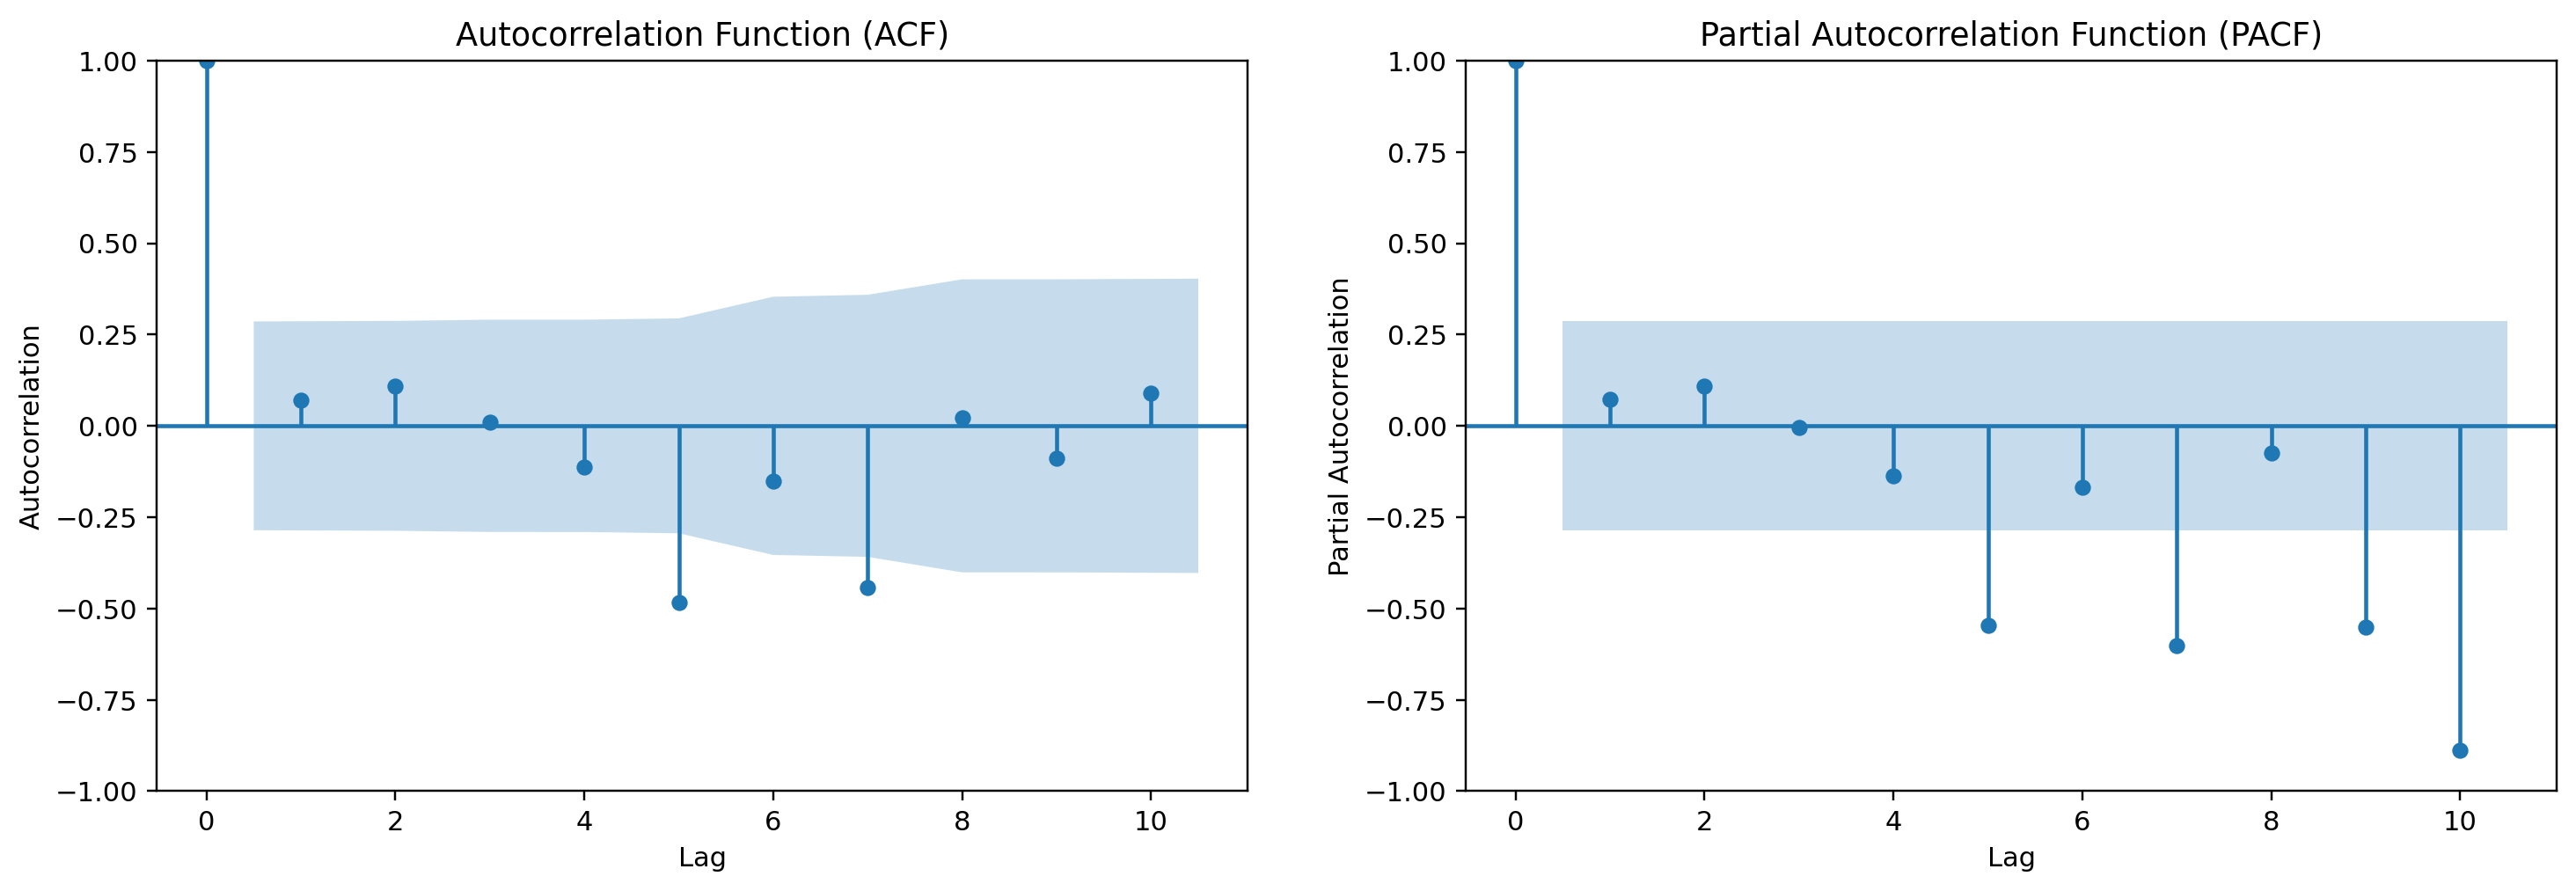

In [80]:
#first to do is looking at the acf and pcf plots of the df_diff

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig,axes = plt.subplots(1,2,figsize=(16,5))

plot_acf(df_diff,lags=10,ax=axes[0],title = "Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

plot_pacf(df_diff,lags = 10,ax=axes[1],title = "Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")

## ARIMA Model

Autoregressive integrated moving average; ARIMA(p,d,q) is a forecasting equation that can make time series stationary with the help of differencing and log techniques when required.

* **p (AR)** -> Effect of past value on model

* **d (I)** -> Nonseasonal differences needed for stationarity

* **q (MA)** -> Lagged forecast errors in the prediction equation

In our case when we look at the ACF and PACF plot, we see that we should use ARIMA(1,1,1) because after the first lag there is a huge decrease in both of the plots. 

Some examples;
ARIMA(1,0,0) -> AR(1) First order regression model


ARIMA(0,0,1) -> MA(1) First order regression model


ARIMA(0,1,0) -> Random walk


ARIMA(1,1,1) -> ARIMA model

In [81]:
#using the ARIMA model for predictiong the future values

#pip install pmdarima

import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_f(series):
    #print(f"Results of Dickey-Fuller Test for column: {column_name}")
    dftest1 = adfuller(series,autolag="AIC",regression="ct")
    dfoutput = pd.Series(dftest1[0:4],index=["Test Statistics","p-value","No lags used","Number of Obs. Used"])
    critical_values = dftest1[4]
    for key, value in critical_values.items():
        dfoutput["Critical Value (%s)"%key] = value
    print(dfoutput)
    
    if dftest1[1] <=0.05:
        print("Conclusion ===>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion ===>")
        print("Fail to reject null hypothesis")
        print("Data is non-stationary")
        
Augmented_Dickey_Fuller_Test_f(df["Prices"])

Test Statistics         -2.058395
p-value                  0.569301
No lags used            10.000000
Number of Obs. Used     37.000000
Critical Value (1%)     -4.226862
Critical Value (5%)     -3.536646
Critical Value (10%)    -3.200240
dtype: float64
Conclusion ===>
Fail to reject null hypothesis
Data is non-stationary


In [82]:
#this was exaclty what we had found earlier
#now we will look a stepwise arima model

stepwise_model = auto_arima(train,start_p=1,start_q=1,max_p=3,max_q=3,seasonal=False,d=None,
                           trace=True,error_action="ignore",suppress_warnings=True,stepwise=True)

stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39.918, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.540, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.483, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.498, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.332, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.509 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -17.666
Date:                Sun, 23 Nov 2025   AIC                             37.332
Time:                        15:20:15   BIC                             38.943
Sample:                    10-31-2020   HQIC                            37.900
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1521      0.033      4.542      0.000       0.086       0.218
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.80   Prob(JB):                         0.90
Heteroskedasticity (H):               1.40   Skew:                             0.17
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This shows that random walk a.k.a ARIMA(0,1,0) is better model. But the reason for that is just because the AIC of ARIMA(1,1,1) is 2 points bigger than the AIC of ARIMA(0,1,0). And actually, I am choosing the ARIMA(1,1,1) to forecast the values.

In [83]:
from statsmodels.tsa.arima.model import ARIMA

order = (1,1,1)

print(f"Fitting ARIMA {order} Model")

model_arima = ARIMA(train,order= order)

model_fit = model_arima.fit()

print(model_fit.summary())

Fitting ARIMA (1, 1, 1) Model
                               SARIMAX Results                                
Dep. Variable:                 Prices   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -16.391
Date:                Sun, 23 Nov 2025   AIC                             38.783
Time:                        15:20:15   BIC                             43.616
Sample:                    10-31-2020   HQIC                            40.487
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9663      0.280     -3.457      0.001      -1.514      -0.418
ma.L1          0.8943      0.427      2.095      0.036       0.058       1.731
sigma2         0.1407 

## What all of those above means?

I mean I dont know the meaning of life but this table is something I know. Lets start.

### Log Likelihood

It is used in statistics and machine learning to measure how well a model explains the data. We use it for its numerical stability , simplification of the units, adaptation efficiency and better interpretation. Lower log likelihood is preffered.

### AIC , BIC and HQIC

Those three are used to predict which model of machine learning is better. If they are smaller then we have a better model.

But what makes the difference between them?

* AIC -> It is best for predictive accuracy, it tends to choose larger models.

* BIC -> It is beast for model identification, finding the true underlying structure. It tends to choose smaller models.

* HQIC -> It tends to choose true model as the number of observations increase.

### AR and MA 

Here ar.L1 means previous observations. Its p-value is less than 0.05, so it is a significant variable. It basically says previous observation has a negative effects. That means if yesterdays price is high todays is low and vice versa.

On the other hand ma.L1 shows how the model's error term in the past period affects current period. Here it is also significant because the p value is less than 0.05. As previous values increase the current period also increases because the coef. is positive unlike ar.1L.

Sigma is the variance of the residuals. It is also significant.


### Diagnostic Tests

* **Ljung-Box (L1) (Q)** : It checks for remaining autocorrelation in the residuals. Its null hypotheisis is no correlation int the data in a chosen lag. Here its lag is 1 and  its statistics 1.62 which makes its p-value something like 0.20. So we fail to reject H0. There is no autocorrelation.

* **Jarque-Bera (JB)** : It tests if the residuals are distributed normally. Null hypothesis is they distributed not normally but here the statistics of JB is 1.32 and the p-value is 0.52 so we fail to reject null hypotheisis. So here the residuals distributed normally.

* **Heteroscedasticity Test** : It looks if the varience of errors are constant or not. H0 is homoscedasticity. Here the p-value is 0.93 which is greater than 0.05 so we fail to reject H0. Residuals are constant.

* **Skew** : Its 0.21 so the residuals are highly positively skewed. But it almost like 0 skew because its like 0.21. There is 3 types of skewness ;
    * *Zero Skewness* : It is when mean = median in a distribution.
    * *Positive Skewness* : Its when mean > median, it is also means right skewness.
    * *Negative Skewness* : Its when mean < median, its also means left skewness.
    
* **Kurtosis** : A normal distribution have kurtosis of 3, It makes a positive kurtosis, also known as leptokurtic.

In [84]:
#forecasting

forecast_steps = len(test)
start_index = len(train)
end_index = start_index + forecast_steps -1

forecast_result = model_fit.predict(start=start_index,end=end_index)
forecast_series = pd.Series(forecast_result.values,index=test.index)

print("Model Performance on test set")
time_series_evaluation_metrics_f(test,forecast_series)

Model Performance on test set
Evaluation metric results:-
MSE is : 0.2846441906766437
MAE is : 0.49231000945067294
RMSE is : 0.5335205625621601
MAPE is : 4.112792082310682
R2 is : -0.05267821995800204



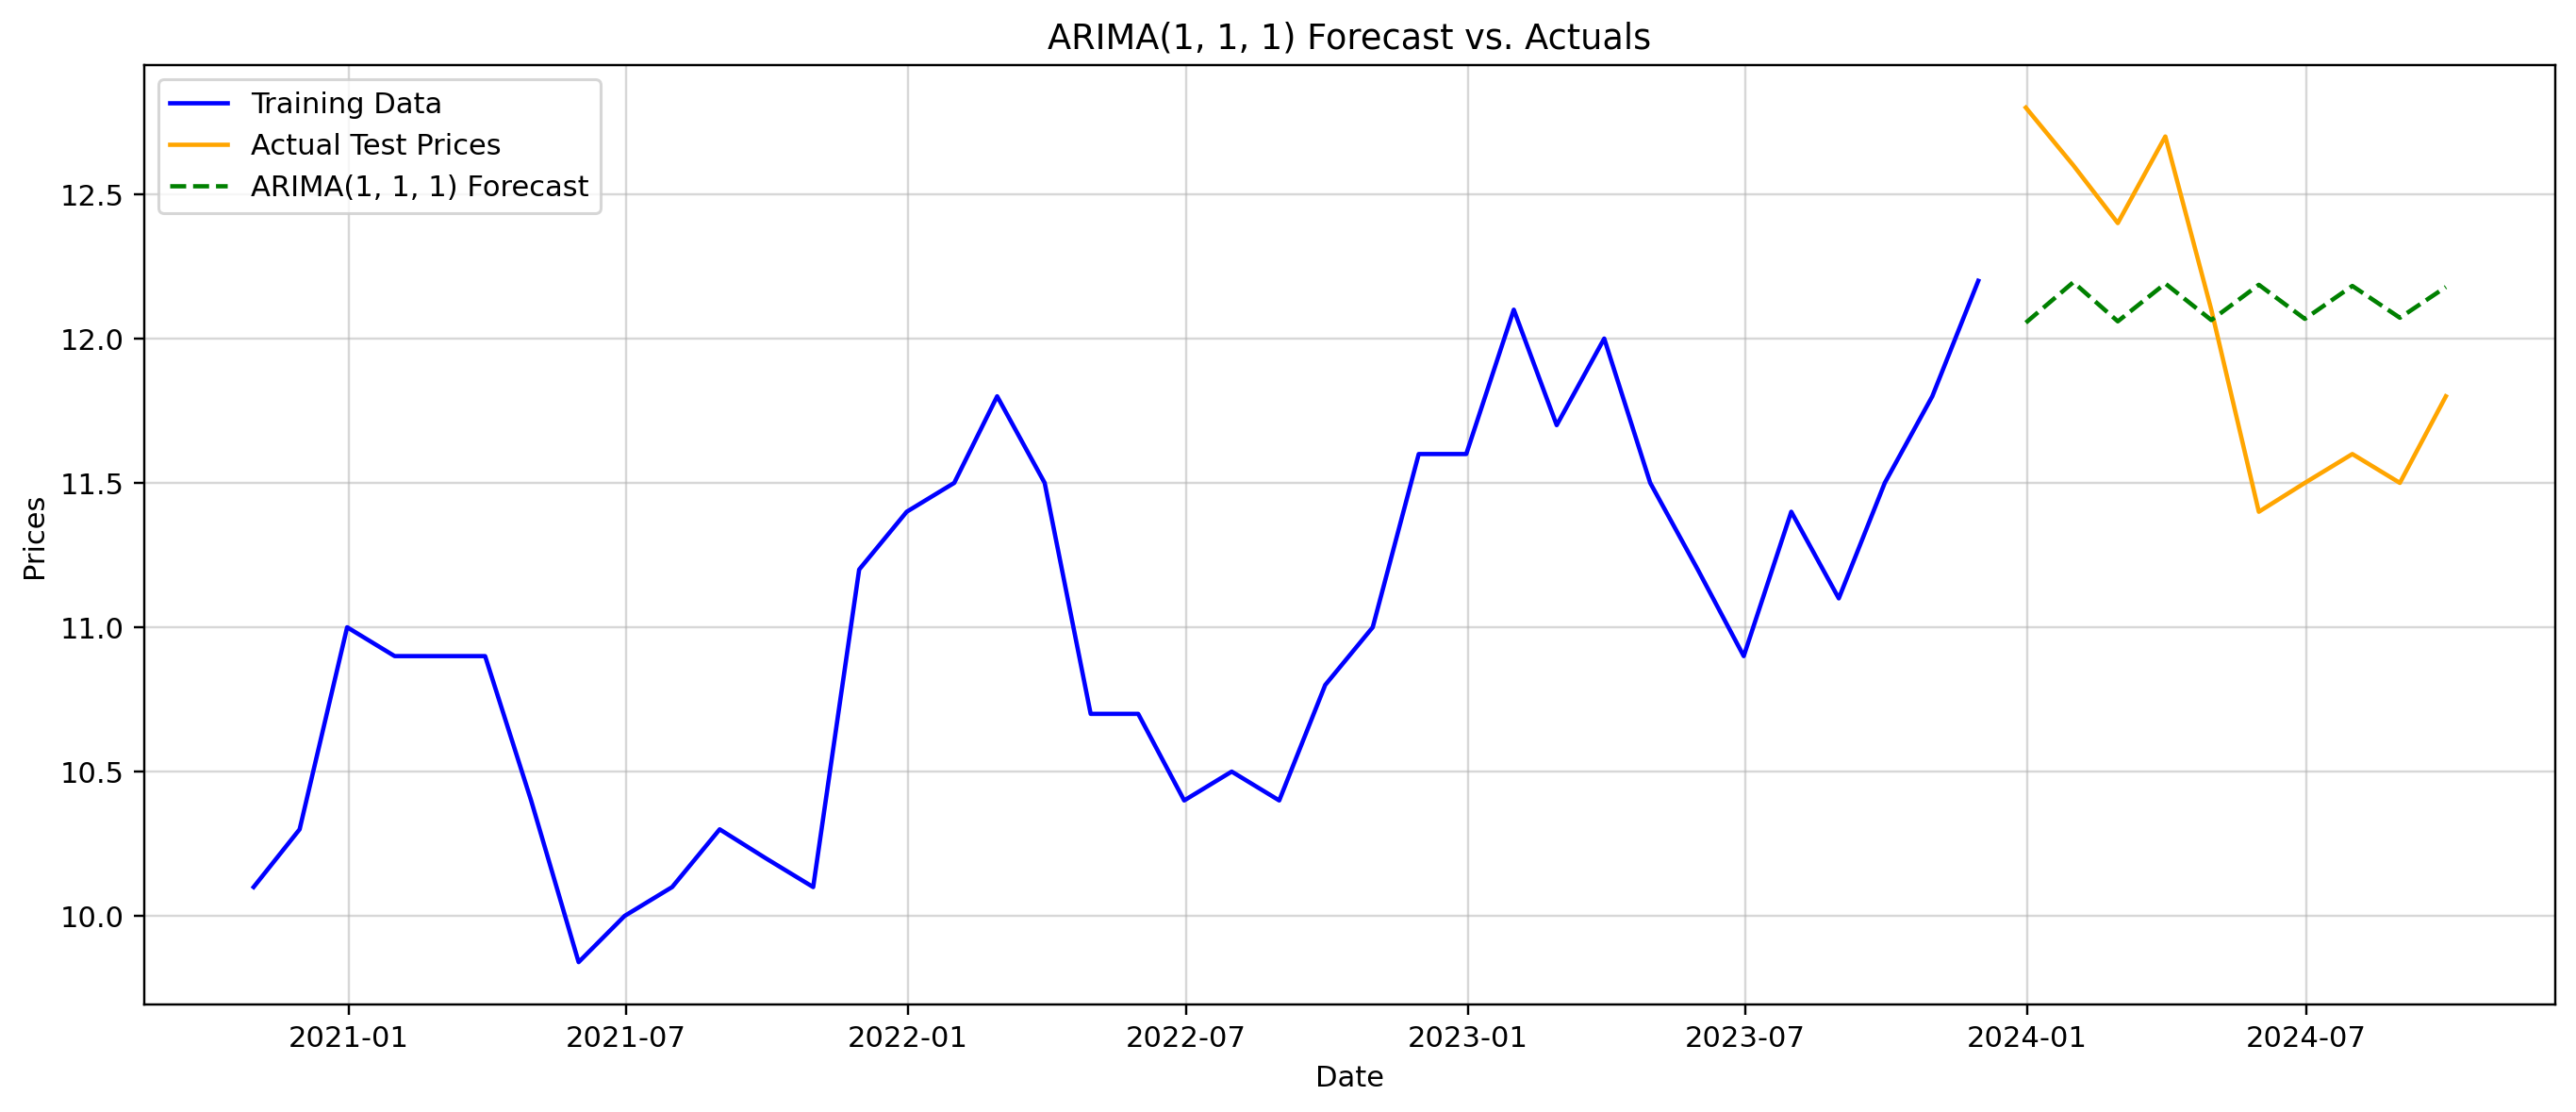

In [85]:

# Plot the training data
plt.plot(train, label='Training Data', color='blue')

# Plot the actual test data
plt.plot(test, label='Actual Test Prices', color='orange')

# Plot the ARIMA forecast
plt.plot(forecast_series, label=f'ARIMA{order} Forecast', color='green', linestyle='--')

plt.title(f'ARIMA{order} Forecast vs. Actuals')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.show()

In [87]:
df.tail()

,Prices
Dates,
2024-05-31,11.4
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8


In [93]:
## date estimate function

start_date = "2020-10-31"
end_date = "2024-09-30"

dates = pd.date_range(start = start_date,end=end_date,freq="M")
N_MONTHS = len(dates)

np.random.seed(42)

df_eom = df["Prices"]

model_arima = ARIMA(df_eom,order=order)

model_fit = model_arima.fit()

def estimate_gas_price(target_date_str,model_fit,full_series):
    historical_end = full_series.index.max()
    try:
        target_date = pd.to_datetime(target_date_str)
    except ValueError:
        return f"Error: Could not parse date '{target_date_str}'. Please use YYYY-MM-DD format."
    start_dt = full_series.index.min()
    end_dt = target_date
    
    try:
        prediction = model_fit.get_prediction(start=start_dt,end=end_dt)
        pred_index = prediction.predicted_mean.index
        closest_pred_date = pred_index[pred_index.get_loc(target_date, method='nearest')]
        
        estimated_price = prediction.predicted_mean.loc[closest_pred_date]
        
        
        if closest_pred_date <= historical_end:
            # Check if the date was in the original historical index
            if closest_pred_date in full_series.index:
                 status = "Historical Estimate (In-Sample)"
            else:
                 status = "Historical Estimate (Interpolated)"
        else:
            status = "Forecasted Price (Extrapolated)"
            
        return (f"{status} for {closest_pred_date.strftime('%Y-%m-%d')}: "
                f"${estimated_price:.4f}")

    except Exception as e:
        return f"Prediction Error: {e}"


In [94]:
future_date = "2025-07-12"
estimate_gas_price(future_date,model_fit,df_eom)

'Forecasted Price (Extrapolated) for 2025-06-30: $11.8397'

## What is all those codes?

Well, here we see that we created a function that has inputs as target date which we want to see whats happen in the future with our model. The second input is the model that we fitted which is ARIMA(1,1,1). The last input is the data in a series format. 

Also we use try except blocks as a safety nets. And there is **prediction** part which is the most crucial one. It is the core calculation. It tells ARIMA model to produce an estimated price for every month from start to end. Here the model draws a line which is a combination of the historical fit and the forecast of the future dates.

**closest_pred_date** also important. Since in the model we have only data at the end of the month. Here we get the nearest month's prediction. And the **estimated_price** is the one that we got from the closest_pred_date and its predicted value.

At the final point we have the status message:

* If the date we selected is in the original data set we have the exact prediction of it

* If the date we selected is again in the original data set but not the end of the month then we have the estimated vaue of closest dates like before and after months.

* The last one is if the date we have selected is out of the the date in our data set then we have a future forcasted price.